# 1. Setup & Préparation

##1.1 Installations et Import des librairies

In [1]:
# === 📦 1. Installation du modèle spaCy ===
# ====== ATTENTION ======
# Cette commande doit être exécutée une seule fois dans le terminal.
"""
conda activate **env_name**
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl
"""

'\nconda activate **env_name**\npip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl\n'

In [2]:
# === 📦 2. Importation des bibliothèques ===

# 🧮 Données
import pandas as pd
import numpy as np

# 📊 Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 🛠️ Utilitaires
import os
import time
import math
import re
import string
import ast
from collections import Counter, defaultdict

# 📚 NLP classique (NLTK, spaCy)
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import spacy

# 🤗 Transformers (HuggingFace)
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel
)

# 🧠 ML / clustering
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch

# 📊 Statistiques
from scipy.stats import mannwhitneyu, entropy

# 📑 Orthographe / grammaire
import requests

# 🕓 Progression
from tqdm import tqdm
tqdm.pandas()

c:\Users\Julien Rouillard\Anaconda3\envs\authenticheck_eda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##1.2 Configuration



In [3]:
# Chemins d’accès
#DATASET_PATH = "data/dataset.csv"
MODEL_DIR = "models/"
FIGURE_DIR = "figures/"

# Colonnes principales
TEXT_COL = "text"
LABEL_COL = "classe"

# Langue et modèles
LANGUAGE = "en"
MAX_SEQ_LEN = 512
BERT_MODEL_NAME = "bert-base-uncased"
STOPWORDS_LANGUAGE = "english"
CONNECTORS_LANGUAGE = "en"
USE_GPU = True  # ⚠️ Adapter selon ton environnement

# Chargement des stopwords dynamiquement selon la langue définie
stop_en = set(stopwords.words(STOPWORDS_LANGUAGE))

# API LanguageTool
LANGUAGETOOL_API_URL = "https://api.languagetool.org/v2/check"
LT_RATE_LIMIT_SECONDS = 3
LT_BATCH_SIZE = 20

# Spacy
nlp = spacy.load("en_core_web_sm")
SENTIMENT_MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"


# Affichage pandas
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", None)

##1.3 Chargement du dataset

In [4]:
#Chargement du dataset
df = pd.read_csv("../datasets_source/Compilation_from_Kaggle_IA_Human.csv")
df.head()

,text,label
0,It always seems impossible until it's done.,0
1,She finished the challenging crossword puzzle.,1
2,"You can't use up creativity. The more you use, the more you have.",0
3,The journey of a thousand miles begins with a single step.,0
4,"Life is short, and it is up to you to make it sweet.",0


##1.4 Aperçu & vérifications initiales

In [5]:
print(df.info())
print("\n")
print(df.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16193 entries, 0 to 16192
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16193 non-null  object
 1   label   16193 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 253.1+ KB
None


                                                               text  \
count                                                         16193   
unique                                                        10024   
top     She prefers reading historical novels over science fiction.   
freq                                                            224   
mean                                                            NaN   
std                                                             NaN   
min                                                             NaN   
25%                                                             NaN   
50%                                               

In [6]:
#Vérifier les valeurs manquantes
df.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
#Création de la colonne "classe" à partir de "label": 0 -> "Humain", 1 -> "IA"
df["classe"] = df["label"].map({0: "Humain", 1: "IA"})

#Vérification
print(df[["label", "classe"]].head())

   label  classe
0      0  Humain
1      1      IA
2      0  Humain
3      0  Humain
4      0  Humain


In [8]:
#Afficher les proportions des labels en %
print(df["classe"].value_counts(normalize=True).round(3))

classe
IA        0.637
Humain    0.363
Name: proportion, dtype: float64


# 2. Prétraitement

##2.1 Nettoyage des données et tokenisation BERT

In [9]:
#Modèle anglais, insensible à la casse (dataset en anglais)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(df.columns)

c:\Users\Julien Rouillard\Anaconda3\envs\authenticheck_eda\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Index(['text', 'label', 'classe'], dtype='object')


In [10]:
#Chaque texte -> liste de wordpieces
df["bert_wp"] = df[TEXT_COL].astype(str).apply(tokenizer.tokenize)
df["bert_wp_len"] = df["bert_wp"].apply(len)

#(Option) IDs token + [CLS]/[SEP] (en prevision du modèle ensuite)
df["bert_ids"] = df[TEXT_COL].astype(str).apply(lambda t: tokenizer.encode(t, add_special_tokens=True))
df["bert_ids_len"] = df["bert_ids"].apply(len)

#Aperçu
df[[TEXT_COL, "bert_wp"]].head()

Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


,text,bert_wp
0,It always seems impossible until it's done.,"[it, always, seems, impossible, until, it, ', s, done, .]"
1,She finished the challenging crossword puzzle.,"[she, finished, the, challenging, cross, ##word, puzzle, .]"
2,"You can't use up creativity. The more you use, the more you have.","[you, can, ', t, use, up, creativity, ., the, more, you, use, ,, the, more, you, have, .]"
3,The journey of a thousand miles begins with a single step.,"[the, journey, of, a, thousand, miles, begins, with, a, single, step, .]"
4,"Life is short, and it is up to you to make it sweet.","[life, is, short, ,, and, it, is, up, to, you, to, make, it, sweet, .]"


In [11]:
def reconstruct_words(wp_tokens):
    """
    Recolle les WordPieces en mots lisibles.
    Ex: ['play', '##ing'] -> ['playing']
    """
    words = []
    current = ""
    for tok in wp_tokens:
        if tok.startswith("##"):
            current += tok[2:]
        else:
            if current:
                words.append(current)
            current = tok
    if current:
        words.append(current)
    return words

# Créer une colonne "bert_words" (mots reconstruits)
df["bert_words"] = df["bert_wp"].apply(reconstruct_words)
df["bert_words_len"] = df["bert_words"].apply(len)

# Aperçu
df[[TEXT_COL, "bert_wp", "bert_words"]].head()

,text,bert_wp,bert_words
0,It always seems impossible until it's done.,"[it, always, seems, impossible, until, it, ', s, done, .]","[it, always, seems, impossible, until, it, ', s, done, .]"
1,She finished the challenging crossword puzzle.,"[she, finished, the, challenging, cross, ##word, puzzle, .]","[she, finished, the, challenging, crossword, puzzle, .]"
2,"You can't use up creativity. The more you use, the more you have.","[you, can, ', t, use, up, creativity, ., the, more, you, use, ,, the, more, you, have, .]","[you, can, ', t, use, up, creativity, ., the, more, you, use, ,, the, more, you, have, .]"
3,The journey of a thousand miles begins with a single step.,"[the, journey, of, a, thousand, miles, begins, with, a, single, step, .]","[the, journey, of, a, thousand, miles, begins, with, a, single, step, .]"
4,"Life is short, and it is up to you to make it sweet.","[life, is, short, ,, and, it, is, up, to, you, to, make, it, sweet, .]","[life, is, short, ,, and, it, is, up, to, you, to, make, it, sweet, .]"


In [12]:
#Version "ponctuation conservée" pour l'analyse de style

def normalize_keep_punct(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_norm"] = df[TEXT_COL].astype(str).apply(normalize_keep_punct)

#Verifier que le nettoyage est bien fait
print(df[[TEXT_COL, "bert_words", "classe"]].head())

                                                                text  \
0                        It always seems impossible until it's done.   
1                     She finished the challenging crossword puzzle.   
2  You can't use up creativity. The more you use, the more you have.   
3         The journey of a thousand miles begins with a single step.   
4               Life is short, and it is up to you to make it sweet.   

                                                                                  bert_words  \
0                                  [it, always, seems, impossible, until, it, ', s, done, .]   
1                                    [she, finished, the, challenging, crossword, puzzle, .]   
2  [you, can, ', t, use, up, creativity, ., the, more, you, use, ,, the, more, you, have, .]   
3                   [the, journey, of, a, thousand, miles, begins, with, a, single, step, .]   
4                     [life, is, short, ,, and, it, is, up, to, you, to, make, it, swee

**Pourquoi BERT change la donne ?**

Pas de stopwords à gérer : la tokenization BERT capture déjà très bien les unités linguistiques.

OOV géré : les mots inconnus sont cassés en sous-mots (##), donc plus de perte.

Ponctuation : elle est séparée proprement et on peut la compter si on veut des stats de style.

Cohérence avec un futur modèle BERT : si on entraîne un classifieur BERT ensuite, mêmes tokens = pas de décalage entre EDA et modèle.

# 3. Analyse exploratoire (EDA)

## 3.1 Longueur des textes

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\9144845.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="classe", y="bert_words_len", data=df, palette="Set2")


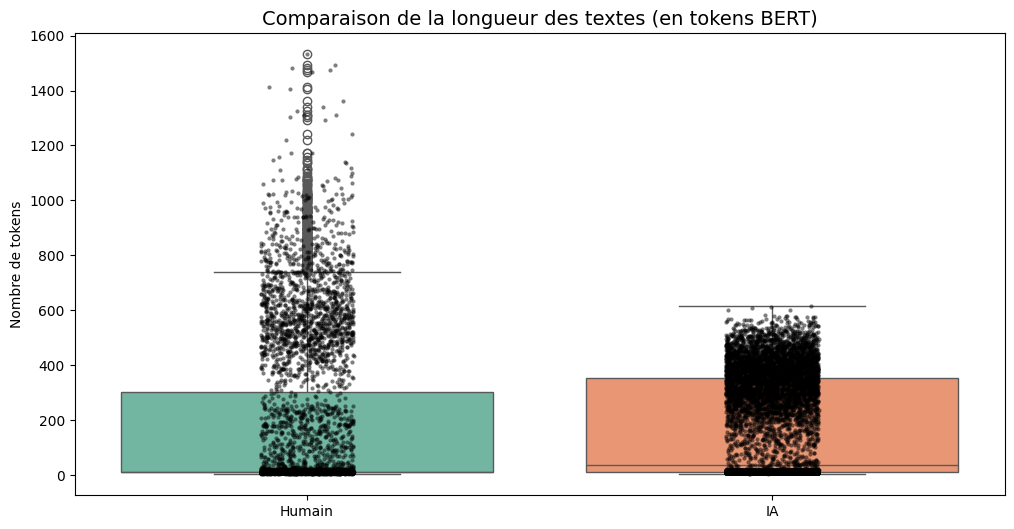

In [13]:
# 1) Boxplot + distribution
plt.figure(figsize=(12,6))
sns.boxplot(x="classe", y="bert_words_len", data=df, palette="Set2")
sns.stripplot(x="classe", y="bert_words_len", data=df, color="black", size=3, alpha=0.5)
plt.title("Comparaison de la longueur des textes (en tokens BERT)", fontsize=14)
plt.xlabel("")
plt.ylabel("Nombre de tokens")
plt.show()

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\2333996218.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="classe", y="bert_words_len", data=df_filtered, palette="Set2")


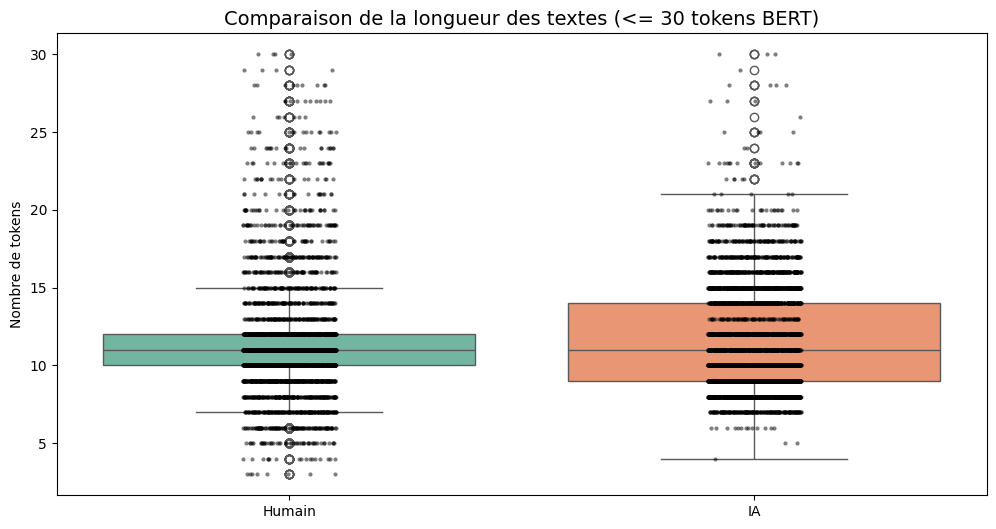

In [14]:
#Filtrer les textes avec longueur <= 30 tokens
df_filtered = df[df["bert_words_len"] <= 30]

plt.figure(figsize=(12,6))
sns.boxplot(x="classe", y="bert_words_len", data=df_filtered, palette="Set2")
sns.stripplot(x="classe", y="bert_words_len", data=df_filtered, color="black", size=3, alpha=0.5)
plt.title("Comparaison de la longueur des textes (<= 30 tokens BERT)", fontsize=14)
plt.xlabel("")
plt.ylabel("Nombre de tokens")
plt.show()

Insight: l'IA a tendance a ecrire des textes plus longs.

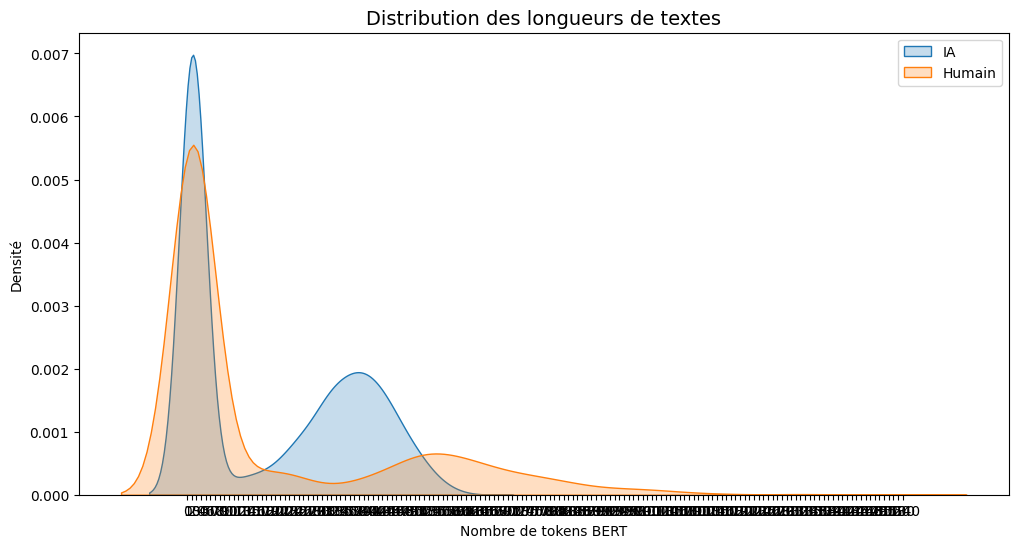

In [15]:
# 2) Distribution KDE
plt.figure(figsize=(12,6))
sns.kdeplot(df[df["classe"]=="IA"]["bert_words_len"], label="IA", fill=True)
sns.kdeplot(df[df["classe"]=="Humain"]["bert_words_len"], label="Humain", fill=True)
plt.title("Distribution des longueurs de textes", fontsize=14)
plt.xlabel("Nombre de tokens BERT")
plt.ylabel("Densité")
plt.legend()
# définir des ticks de 10 en 10
plt.xticks(ticks=range(0, df["bert_words_len"].max()+10, 10))
plt.show()

Insight: concentration des longueurs de mots autour de 8 a 15 tokens chez l'humain.

In [16]:
# 3) Test statistique Mann–Whitney U (non paramétrique, car distributions souvent non normales)
ia_lengths = df[df["classe"]=="IA"]["bert_words_len"]
human_lengths = df[df["classe"]=="Humain"]["bert_words_len"]

stat, p = mannwhitneyu(ia_lengths, human_lengths, alternative="two-sided")

print("Mann–Whitney U test")
print(f"Statistique U = {stat:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("✅ Différence significative entre IA et Humain (longueur des textes)")
else:
    print("❌ Pas de différence significative détectée")

Mann–Whitney U test
Statistique U = 33397446.50, p-value = 0.0000
✅ Différence significative entre IA et Humain (longueur des textes)


In [17]:
#Calcul de statistiques descriptives et test de significativité (Mann-Whitney)
#pour comparer la distribution des longueurs de texte entre IA et Humain
#selon différentes mesures : tokens BERT, nombre de mots, longueur en caractères.

#Nombre de mots (en découpant text_norm par les espaces)
df["nb_mots"] = df["text_norm"].apply(lambda x: len(x.split()))

#Longueur du texte en caractères
df["longueur"] = df["text_norm"].apply(len)

#Colonnes à comparer
cols = ["bert_words_len", "nb_mots", "longueur"]

results = []

for col in cols:
    ia_vals = df[df["classe"]=="IA"][col]
    human_vals = df[df["classe"]=="Humain"][col]

    #Stats descriptives
    ia_mean, ia_median, ia_std = ia_vals.mean(), ia_vals.median(), ia_vals.std()
    human_mean, human_median, human_std = human_vals.mean(), human_vals.median(), human_vals.std()

    #Test Mann–Whitney (test non-paramétrique pour comparaison de distributions)
    stat, p = mannwhitneyu(ia_vals, human_vals, alternative="two-sided")

    results.append({
        "Mesure": col,
        "IA_mean": round(ia_mean, 2), "IA_median": round(ia_median, 2), "IA_std": round(ia_std, 2),
        "Humain_mean": round(human_mean, 2), "Humain_median": round(human_median, 2), "Humain_std": round(human_std, 2),
        "U_stat": round(stat, 2), "p_value": round(p, 4)
    })

#Tableau comparatif des résultats
results_df = pd.DataFrame(results)
results_df

,Mesure,IA_mean,IA_median,IA_std,Humain_mean,Humain_median,Humain_std,U_stat,p_value
0,bert_words_len,176.85,36.0,181.43,175.46,12.0,274.80,33397446.5,0.0
1,nb_mots,150.09,31.0,154.17,153.93,11.0,242.09,32813263.0,0.0
2,longueur,963.76,208.0,995.63,895.41,68.0,1384.08,35737382.5,0.0


##3.2 Fréquence des mots par classe (IA vs humain)

In [18]:
# (1) Parser bert_words si nécessaire
df["bert_words"] = df["bert_words"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# (2) Expression régulière pour détecter les mots (exclut la ponctuation)
word_re = re.compile(r"^[a-z0-9]+$")

def words_only(tokens):
    return [t.lower() for t in tokens if word_re.match(t.lower())]

# (3) Extraire tous les mots (hors ponctuation) pour chaque classe
ia_tokens = [w for ws in df[df["classe"] == "IA"]["bert_words"] for w in words_only(ws)]
hu_tokens = [w for ws in df[df["classe"] == "Humain"]["bert_words"] for w in words_only(ws)]

# (4) Compter les fréquences
ia_word_freq = Counter(ia_tokens)
human_word_freq = Counter(hu_tokens)

In [19]:
#Top n mots dans chaque classe
top_n = 20
ia_top_words_set = set([w for w, _ in ia_word_freq.most_common(top_n)])
human_top_words_set = set([w for w, _ in human_word_freq.most_common(top_n)])

#Union des deux sets
words_to_compare = ia_top_words_set.union(human_top_words_set)

#Créer un DataFrame avec les vraies fréquences
freq_compare_words = pd.DataFrame([
    {
        "word": w,
        "IA_freq": ia_word_freq.get(w, 0),
        "Humain_freq": human_word_freq.get(w, 0)
    }
    for w in words_to_compare
])

#Affichage du tableau
print("Comparatif Top mots IA vs Humain (réel)")
display(freq_compare_words.sort_values(by=["Humain_freq", "IA_freq"], ascending=False))

Comparatif Top mots IA vs Humain (réel)


,word,IA_freq,Humain_freq
29,the,78565,51885
22,to,49095,25349
5,of,39973,23029
11,a,46608,20298
14,and,61598,18714
18,in,23079,17157
17,is,6434,13426
1,that,17218,11576
0,for,13823,9947
19,it,6697,9526


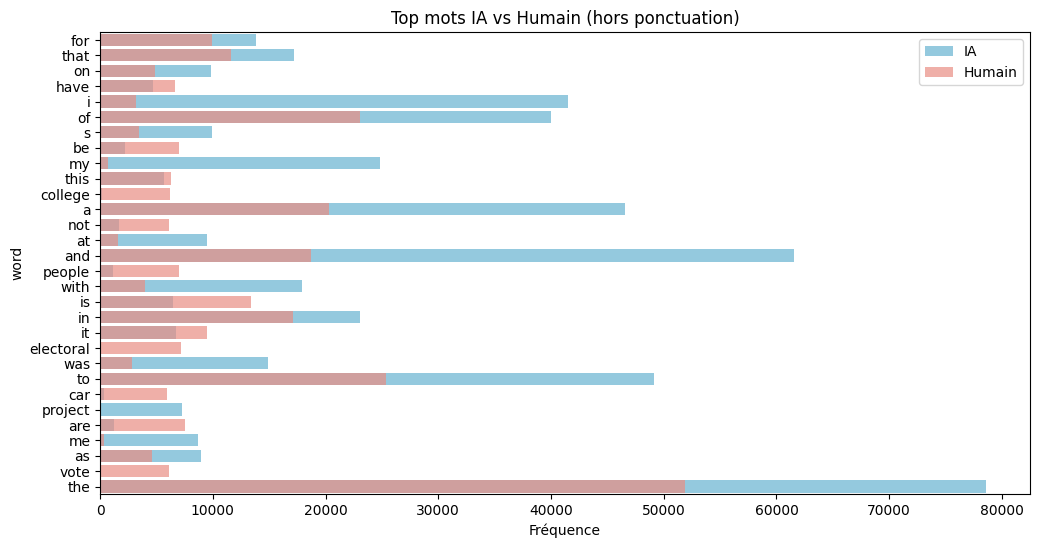

In [20]:
#Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(y="word", x="IA_freq", data=freq_compare_words, color="skyblue", label="IA")
sns.barplot(y="word", x="Humain_freq", data=freq_compare_words, color="salmon", label="Humain", alpha=0.7)
plt.title("Top mots IA vs Humain (hors ponctuation)")
plt.xlabel("Fréquence")
plt.legend()
plt.show()

insight: recours recurrent a des mots tres simples cote humain

##3.3 Wordclouds par classe

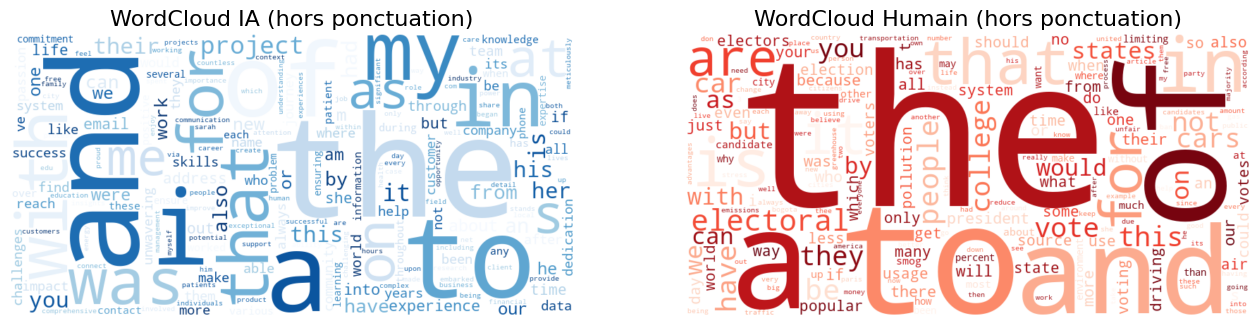

In [21]:
#Générer les wordclouds à partir des fréquences
wc_ia = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate_from_frequencies(ia_word_freq)
wc_human = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate_from_frequencies(human_word_freq)

#Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16,8))

axes[0].imshow(wc_ia, interpolation="bilinear")
axes[0].set_title("WordCloud IA (hors ponctuation)", fontsize=16)
axes[0].axis("off")

axes[1].imshow(wc_human, interpolation="bilinear")
axes[1].set_title("WordCloud Humain (hors ponctuation)", fontsize=16)
axes[1].axis("off")

plt.show()


## 3.4 Nombre de majuscules

In [22]:
#Fonction comptant le nombre de majuscules par texte.
def count_uppercase(text):
  """Compte le nombre de majuscules dans un texte."""
  return sum(1 for t in text if t.isupper())

#Ajout d'une colonne "nb_uppercase"
df["nb_uppercase"] = df["text"].apply(count_uppercase)

#Ajout d'une colonne "len" correspondant à la longueur du texte brut.
df["len"] = df["text"].apply(len)

#Ajout d'une colonne "frequency_uppercase"
df["frequency_uppercase"] = df["nb_uppercase"] / df["len"]

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\1914800086.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=metric, data=df, palette="Set2")


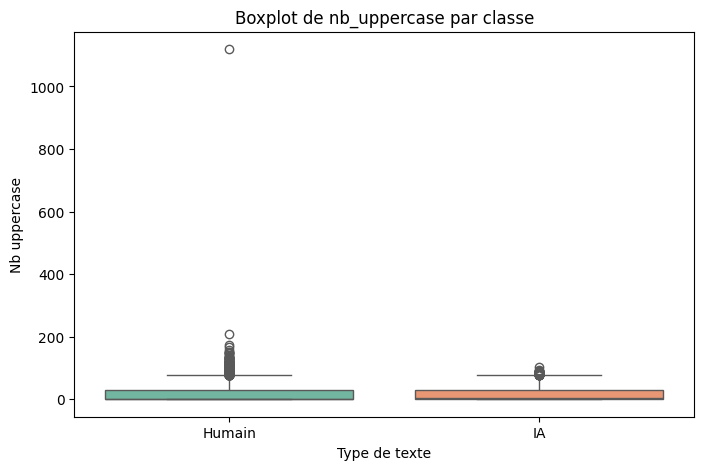

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\1914800086.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=group_col, y=metric, data=df, estimator="mean", ci=95, palette="Set2")
C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\1914800086.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_col, y=metric, data=df, estimator="mean", ci=95, palette="Set2")


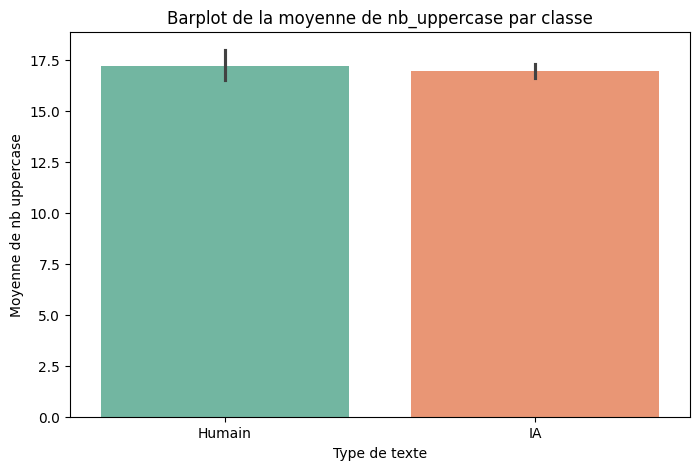

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\1914800086.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=metric, data=df, palette="Set2")


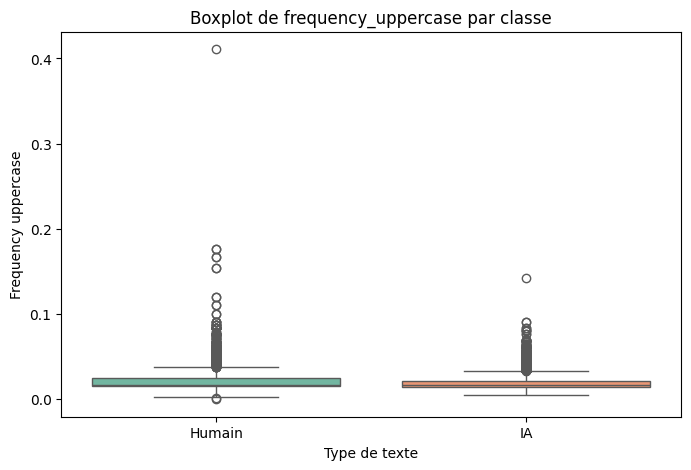

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\1914800086.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=group_col, y=metric, data=df, estimator="mean", ci=95, palette="Set2")
C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\1914800086.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_col, y=metric, data=df, estimator="mean", ci=95, palette="Set2")


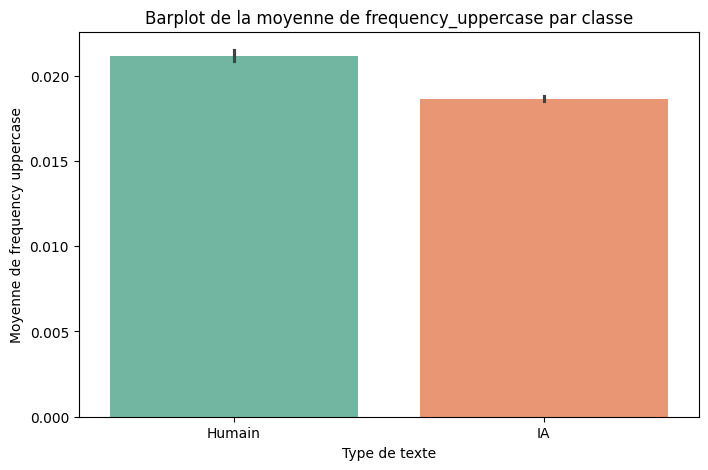

In [23]:
# ==== Calcul des colonnes nécessaires ====
def add_uppercase_features(df, text_col="text"):
    df = df.copy()
    """Ajoute les colonnes liées aux majuscules."""
    df["nb_uppercase"] = df[text_col].apply(lambda x: sum(1 for t in x if t.isupper()))
    df["len"] = df[text_col].apply(len)
    df["frequency_uppercase"] = df["nb_uppercase"] / df["len"]
    return df

df = add_uppercase_features(df)


# ==== Fonction générique pour afficher les graphes ====

def plot_uppercase_metrics(df, metrics=["nb_uppercase", "frequency_uppercase"], group_col="classe"):
    """Affiche boxplot + barplot pour chaque métrique donnée."""
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=group_col, y=metric, data=df, palette="Set2")
        plt.title(f"Boxplot de {metric} par classe")
        plt.xlabel("Type de texte")
        plt.ylabel(metric.replace("_", " ").capitalize())
        plt.show()

        plt.figure(figsize=(8, 5))
        sns.barplot(x=group_col, y=metric, data=df, estimator="mean", ci=95, palette="Set2")
        plt.title(f"Barplot de la moyenne de {metric} par classe")
        plt.xlabel("Type de texte")
        plt.ylabel(f"Moyenne de {metric.replace('_', ' ')}")
        plt.show()


# ==== Appel de la fonction ====
plot_uppercase_metrics(df)


Insigh: On observe une différence dans la fréquence des majuscules entre ia et humain.
Suggestion: Garder uniquement la fréquence de majuscules pour la création du modèle parce que le nombre de majuscules est trop lié à notre dataset. Si l'on essaie par la suite de prédire un texte long de trois pages, forcément, il aura beaucoup de majuscules (bien plus que tous les textes de notre dataset).

In [24]:
#Suppression de la colonne "nb_uppercase"
df = df.drop("nb_uppercase", axis=1)

##3.5 Ponctuation : extraction, fréquence, total

In [25]:
#Liste des signes de ponctuation standards
punctuations = list(string.punctuation)

#Fonction pour extraire les ponctuations d'un texte
def extract_punct(text):
    return [char for char in text if char in punctuations]

#Appliquer à chaque texte
df["punctuation_list"] = df["text"].apply(extract_punct)


#Grouper par classe et concaténer toutes les ponctuations
punct_by_class = df.groupby("classe")["punctuation_list"].sum()

#Créer un compteur par classe
punct_freq_by_class = {
    label: Counter(punct_list)
    for label, punct_list in punct_by_class.items()
}
#Affichage lisible
for label, counter in punct_freq_by_class.items():
    print(f"Ponctuation fréquente dans la classe {label}:")
    for punct, count in counter.most_common(10):
        print(f"  '{punct}': {count}")
    print()


Ponctuation fréquente dans la classe Humain:
  '.': 61408
  ',': 34274
  '"': 10537
  ''': 7407
  '?': 1485
  ':': 766
  '!': 558
  '%': 397
  '-': 157
  '[': 140

Ponctuation fréquente dans la classe IA:
  '.': 108135
  ',': 79699
  ''': 17543
  '-': 11564
  '@': 4310
  ':': 3533
  '"': 1981
  '*': 1592
  '/': 1315
  '_': 1246



## 3.6 Emojis : extraction, fréquence

In [26]:
#Regex emoji (basique, pour capturer la majorité)
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags=re.UNICODE)

def extract_emojis(text):
    return emoji_pattern.findall(text)


df["emojis"] = df["text"].apply(extract_emojis)



#Extraire emojis par classe
ia_emojis = [e for sublist in df[df["classe"]=="IA"]["emojis"] for e in sublist]
human_emojis = [e for sublist in df[df["classe"]=="Humain"]["emojis"] for e in sublist]

ia_emoji_freq = Counter(ia_emojis)
human_emoji_freq = Counter(human_emojis)

print("Top emojis IA:", ia_emoji_freq.most_common(10))
print("Top emojis Humain:", human_emoji_freq.most_common(10))


Top emojis IA: []
Top emojis Humain: []


## 3.7 Stopwords : ratio par texte

In [27]:
#Utiliser la langue définie dans STOPWORDS_LANGUAGE
stop_words = set(stopwords.words(STOPWORDS_LANGUAGE))

def count_stopwords(words, stop_words):
    return sum(1 for w in words if w.lower() in stop_words)

df["n_stopwords"] = df["bert_words"].apply(lambda words: count_stopwords(words, stop_words))
df["stopwords_ratio"] = df["n_stopwords"] / df["bert_words_len"]

print(df[[TEXT_COL, "bert_words_len", "n_stopwords", "stopwords_ratio"]].head())

                                                                text  \
0                        It always seems impossible until it's done.   
1                     She finished the challenging crossword puzzle.   
2  You can't use up creativity. The more you use, the more you have.   
3         The journey of a thousand miles begins with a single step.   
4               Life is short, and it is up to you to make it sweet.   

   bert_words_len  n_stopwords  stopwords_ratio  
0              10            4         0.400000  
1               7            2         0.285714  
2              18           11         0.611111  
3              12            5         0.416667  
4              15            9         0.600000  


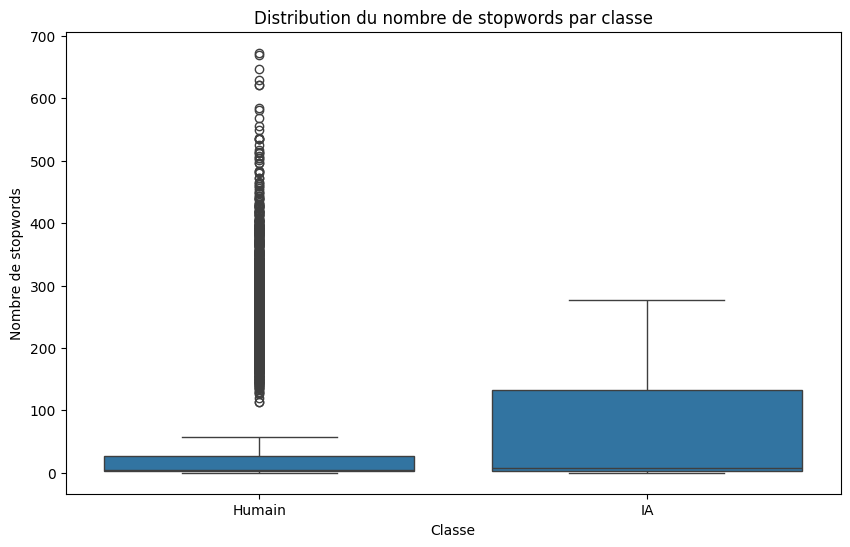

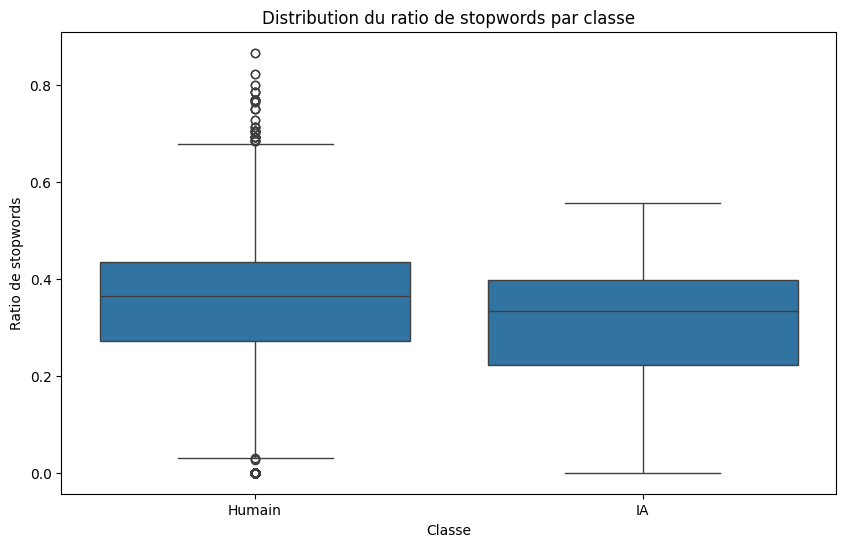

In [28]:
#Exemple d'affichage : distribution du nombre de stopwords par classe
plt.figure(figsize=(10,6))
sns.boxplot(x="classe", y="n_stopwords", data=df)
plt.title("Distribution du nombre de stopwords par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre de stopwords")
plt.show()

#Afficher la proportion (ratio) de stopwords par classe
plt.figure(figsize=(10,6))
sns.boxplot(x="classe", y="stopwords_ratio", data=df)
plt.title("Distribution du ratio de stopwords par classe")
plt.xlabel("Classe")
plt.ylabel("Ratio de stopwords")
plt.show()

## 3.8 Connecteurs logiques : détection, comptage

In [29]:
connectives = {
    'addition': {
        'and', 'also', 'furthermore', 'moreover', 'in addition', 'besides', 'as well', 'what is more',
        'not only... but also', 'similarly', 'likewise'
    },
    'contrast': {
        'but', 'however', 'on the other hand', 'nevertheless', 'nonetheless', 'yet', 'still',
        'even so', 'although', 'though', 'whereas', 'while', 'in contrast', 'conversely'
    },
    'cause': {
        'because', 'since', 'as', 'due to', 'owing to', 'thanks to', 'considering that', 'for the reason that'
    },
    'consequence': {
        'so', 'therefore', 'thus', 'hence', 'as a result', 'consequently', 'accordingly', 'for this reason'
    },
    'concession': {
        'although', 'even though', 'though', 'while', 'granted that', 'admittedly', 'it is true that', 'nonetheless'
    },
    'example': {
        'for example', 'for instance', 'such as', 'like', 'to illustrate', 'namely', 'including', 'in particular'
    },
    'purpose': {
        'so that', 'in order to', 'in order that', 'so as to', 'to', 'for the purpose of', 'with the aim of'
    },
    'time': {
        'first', 'then', 'next', 'after that', 'afterwards', 'before', 'finally', 'meanwhile',
        'eventually', 'at the same time', 'subsequently'
    },
    'summary': {
        'in conclusion', 'to conclude', 'in summary', 'to sum up', 'overall', 'in short', 'all in all', 'ultimately'
    }
}


def detect_connectives(words, connectives):
    detected = defaultdict(list)
    text = ' '.join(words).lower()

    for category, phrases in connectives.items():
        for phrase in phrases:
            if phrase in text:
                detected[category].append(phrase)

    return dict(detected)


df["connectives_detected"] = df["bert_words"].apply(lambda words: detect_connectives(words, connectives))



def flatten_categories(d):
    return Counter({cat: len(lst) for cat, lst in d.items()})

df["connective_counts"] = df["connectives_detected"].apply(flatten_categories)

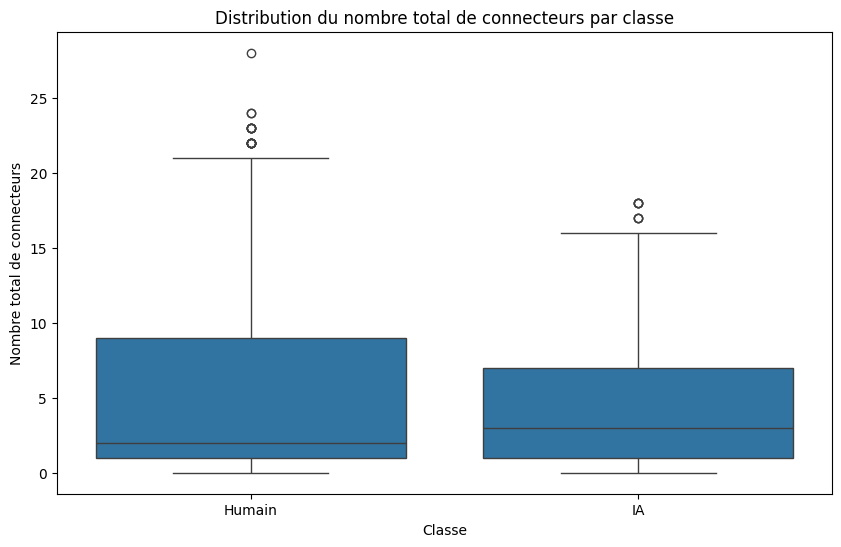

In [30]:
#Ajouter une colonne avec le nombre total de connecteurs (somme des counts par catégorie)
df["n_connectives"] = df["connective_counts"].apply(lambda c: sum(c.values()))

#Visualiser le total par classe
plt.figure(figsize=(10,6))
sns.boxplot(x="classe", y="n_connectives", data=df)
plt.title("Distribution du nombre total de connecteurs par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre total de connecteurs")
plt.show()


## 3.9 Références à soi (ex: "I", "me", "myself")

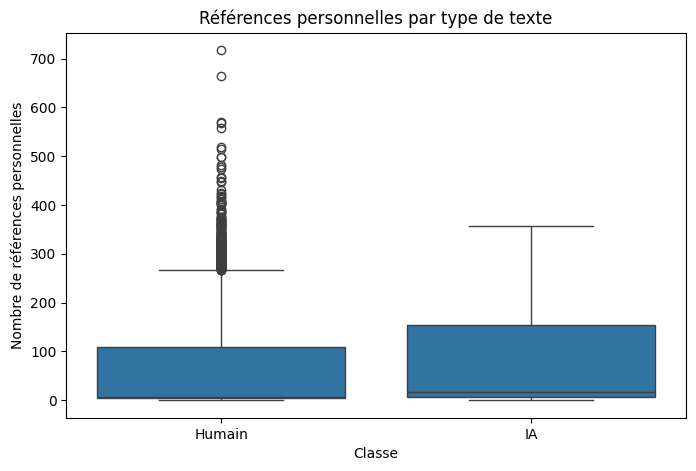

classe
Humain    60.39092
IA        79.10929
Name: personal_refs, dtype: float64

In [31]:
#Liste des references potentielles dans "text"
personal_keywords = [
    "i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves", "when i was", "as a child", "growing up",
    "used to", "i remember", "i recall", "once", "back then",
    "in my life", "in my childhood", "i had", "i used to", "earlier", "my family", "my friends", "my house", "my job", "my school",
    "my favorite", "my experience", "my story", "my journey", "i think", "i feel", "i believe", "i know", "i hope",
    "i love", "i hate", "i was happy", "i was sad", "i was scared"
    ]

def count_personal_references(text):
    text = text.lower()
    return sum(text.count(kw) for kw in personal_keywords)

df["personal_refs"] = df["text"].apply(count_personal_references)



#Boxplot pour visualiser la distribution
plt.figure(figsize=(8,5))
sns.boxplot(x="classe", y="personal_refs", data=df)
plt.title("Références personnelles par type de texte")
plt.xlabel("Classe")
plt.ylabel("Nombre de références personnelles")
plt.show()

#Moyenne par classe
df.groupby("classe")["personal_refs"].mean()




#Essayer avec le pourcentage plutot








In [32]:
personal_experienced_keywords = [
    "when i was", "as a child", "growing up",
    "used to", "i remember", "i recall", "once", "back then",
    "in my life", "in my childhood", "i had", "i used to", "earlier"
    ]

def count_personal_references(text):
    text = text.lower()
    return sum(text.count(kw) for kw in personal_experienced_keywords)

df["personal_refs"] = df["text"].apply(count_personal_references)

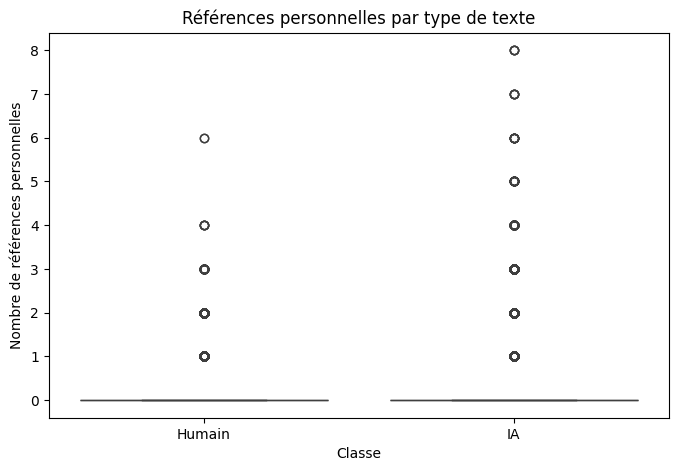

classe
Humain    0.231423
IA        0.375776
Name: personal_refs, dtype: float64

In [33]:
#Boxplot pour visualiser la distribution
plt.figure(figsize=(8,5))
sns.boxplot(x="classe", y="personal_refs", data=df)
plt.title("Références personnelles par type de texte")
plt.xlabel("Classe")
plt.ylabel("Nombre de références personnelles")
plt.show()

#Moyenne par classe
df.groupby("classe")["personal_refs"].mean()

# 4. Analyse linguistique

## 4.1 Analyse du Sentiment

In [34]:
#Charger le modèle et le tokenizer
tokenizer = AutoTokenizer.from_pretrained(SENTIMENT_MODEL_NAME)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(SENTIMENT_MODEL_NAME)


#Noms des classes de sentiment attendues par le modèle (ex: négatif, neutre, positif)
sentiment_class_names = ["negative", "neutral", "positive"]

#Mapping entre les étiquettes du modèle et les classes de sentiment lisibles
sentiment_label_mapping = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}


c:\Users\Julien Rouillard\Anaconda3\envs\authenticheck_eda\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
#Créer le pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=sentiment_model,
    tokenizer=tokenizer,
    top_k=None #Nécessaire pour obtenir les trois probabilités
)


In [36]:
#Fonction ressortant les sentiments pour chaque texte
def get_sentiment_probs(text):
  """
  Retourne 3 features (pos, neg, neu)
  décrivant la positivité, la négativité
  et la neutralité du texte.
  """

  result = sentiment_analyzer(text)[0] #Liste de dict.

  score_dict = {sentiment_label_mapping [r["label"]]: r["score"] for r in result}

  #Vérification da la présence de chaque label
  for label in sentiment_class_names: #La variable "sentiment_class_names" a été déclarée plus haut.
    if label not in score_dict:
      score_dict[label]=0

  return pd.Series(
      [score_dict["pos"], score_dict["neg"], score_dict["neu"]],
      index=["pos", "neg", "neu"]
  )

## 4.2 Analyse PART-OF-SPEECH (POS)

In [37]:
#Sample équilibré (200 IA et 200 Humain)
human_texts = df[df["classe"] == "Humain"][TEXT_COL].sample(200, random_state=42)
ai_texts = df[df["classe"] == "IA"][TEXT_COL].sample(200, random_state=42)

#Pré-tokenisation unique : stockage des objets Doc dans une colonne df["doc"
df["text"] = df["text"].astype(str)  # Assure-toi que ce sont bien des strings
df["doc"] = list(nlp.pipe(df["text"].tolist(), batch_size=256, disable=["ner", "lemmatizer"]))


In [38]:
import re

#Regex qui détecte la présence d'au moins un caractère alphabétique (avec accents) ou numérique dans le token
WORD_REGEX = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ0-9]")

def _is_word_tok(tok):
    return (not tok.is_space) and (not tok.is_punct) and WORD_REGEX.search(tok.text) is not None

In [39]:
def extract_pos_features(doc):
    #Comptage POS
    pos_counts = Counter(t.pos_ for t in doc if not t.is_space)
    total_tokens = sum(pos_counts.values())

    #Calcul en proportions
    pos_proportions = {k: v / total_tokens for k, v in pos_counts.items()}

    #Nombre et longueur des phrases
    sentences = list(doc.sents)
    n_sentences = len(sentences)
    avg_sentences_len = (
        sum(len([t for t in sent if not t.is_space]) for sent in sentences) / n_sentences
        if n_sentences > 0 else 0
    )

    features = {
        "n_sentences": n_sentences,
        "average_sentences_length": avg_sentences_len,
    }
    features.update(pos_proportions)
    return features

In [40]:
#Extraction features à partir de df["doc"]
features_list = []
for doc, text in zip(df["doc"], df["text"]):
    feats = extract_pos_features(doc)
    feats["len_chars"] = len(text)
    len_tokens_all = len(doc)
    len_words = sum(1 for t in doc if _is_word_tok(t))
    feats["len_tokens_all"] = len_tokens_all
    feats["len_words"] = len_words
    feats["len_chars_per_word"] = len(text) / max(1, len_words)
    feats["len_tokens_per_word"] = len_tokens_all / max(1, len_words)
    features_list.append(feats)

features_df = pd.DataFrame(features_list, index=df.index)
df = pd.concat([df, features_df], axis=1)

features_columns = features_df.columns

In [41]:
#Fonction pos_count(docs) + application sur échantillons humains/IA
def pos_count(docs):
    counts = Counter()
    total = 0
    for doc in docs:
        for token in doc:
            if token.pos_ in ["PRON", "NOUN", "VERB", "ADJ", "ADV"]:
                counts[token.pos_] += 1
                total += 1
    return counts, total

#Utilisation avec la colonne df["doc"] de pretokenisation
human_docs = df[df[LABEL_COL] == "Humain"]["doc"].sample(200, random_state=42)
ai_docs    = df[df[LABEL_COL] == "IA"]["doc"].sample(200, random_state=42)

human_counts, human_total = pos_count(human_docs)
ai_counts, ai_total = pos_count(ai_docs)


In [42]:
## proportion ##
human_prop = {pos: human_counts[pos]/human_total for pos in human_counts}
ai_prop    = {pos: ai_counts[pos]/ai_total for pos in ai_counts}

print("proportion humain :", human_prop)
print("proportion IA :", ai_prop)

proportion humain : {'ADV': 0.08886863939379407, 'VERB': 0.23015682701069493, 'NOUN': 0.4097165603568174, 'PRON': 0.13433408469617764, 'ADJ': 0.13692388854251594}
proportion IA : {'ADJ': 0.14455208446718187, 'NOUN': 0.4430717317949276, 'VERB': 0.21862414281049308, 'PRON': 0.14498748231196257, 'ADV': 0.048764558615434855}


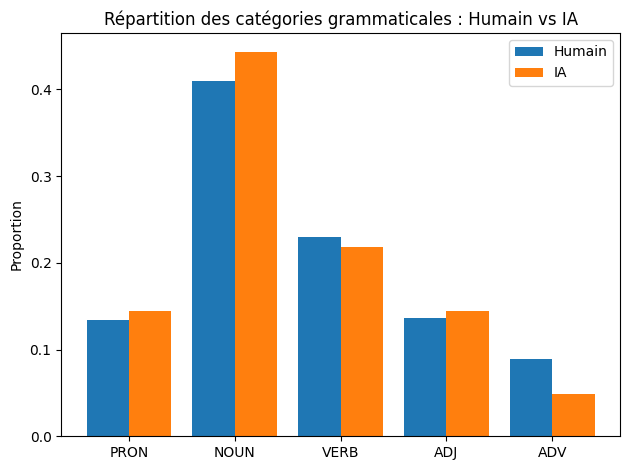

In [43]:
#Liste des catégories grammaticales (POS tags) à visualiser
pos_tags = ["PRON", "NOUN", "VERB", "ADJ", "ADV"]

#Récupération des proportions par type
human_values = [human_prop.get(tag, 0) for tag in pos_tags]
ai_values = [ai_prop.get(tag, 0) for tag in pos_tags]

#Positionnement des barres
x = np.arange(len(pos_tags))
width = 0.4

#Création du graphique
fig, ax = plt.subplots()

ax.set_xticks(x)
ax.set_xticklabels(pos_tags)
ax.bar(x - width/2, human_values, width, label="Humain")
ax.bar(x + width/2, ai_values,    width, label="IA")

plt.ylabel("Proportion")
plt.title("Répartition des catégories grammaticales : Humain vs IA")
plt.legend()
plt.tight_layout()
plt.show()

## 4.3 Statistiques syntaxiques (longueur des phrases, ponctuation, POS, etc.)

In [44]:
#Construction d'un dataset "syntaxe et grammaire" pour faire de l'EDA + facilement
columns_syntax = ["text", "classe"] + features_columns.tolist()
df_syntax = df[columns_syntax]

In [45]:
# 1. Moyenne des features par classe, transposée
df_stats = df_syntax.groupby("classe").mean(numeric_only=True).T

# 2. Calcul du ratio (IA vs Humain)
if "IA" in df_stats.columns and "Humain" in df_stats.columns:
    df_stats["IA_vs_Humain_%"] = (df_stats["IA"] / df_stats["Humain"] * 100).round(1)
else:
    print("Erreur : les colonnes 'IA' et 'Humain' ne sont pas présentes.")

# 3. Affichage
display(df_stats.sort_values(by="IA_vs_Humain_%", ascending=False))

classe,Humain,IA,IA_vs_Humain_%
NOUN,0.261677,0.303790,116.1
average_sentences_length,13.255386,15.316735,115.6
ADP,0.099062,0.114000,115.1
len_chars_per_word,6.047518,6.594289,109.0
len_chars,896.307941,963.832040,107.5
len_tokens_per_word,1.141131,1.134561,99.4
len_tokens_all,175.443122,172.748739,98.5
len_words,155.385309,152.697149,98.3
DET,0.109250,0.106732,97.7
PUNCT,0.114531,0.111566,97.4


In [46]:
def get_class_pos_proportions(texts):
    total_counts = Counter()
    total_tokens = 0
    for doc in nlp.pipe(texts, disable=["ner"]):
        tokens = [t for t in doc if not t.is_space]
        total_counts.update(t.pos_ for t in tokens)
        total_tokens += len(tokens)
    return {pos: round(count / total_tokens * 100) for pos, count in total_counts.items()}

#Textes par classe
texts_ia = df[df["classe"] == "IA"]["text"].tolist()
texts_human = df[df["classe"] == "Humain"]["text"].tolist()

#Proportions globales
ia_pos = get_class_pos_proportions(texts_ia)
human_pos = get_class_pos_proportions(texts_human)

#Fusion dans un DataFrame
df_pos_compare = pd.DataFrame([ia_pos, human_pos], index=["IA", "Humain"]).T

#Calcul du rapport IA vs Humain (%), avec gestion des NaN / inf
df_pos_compare["IA_vs_Humain_%"] = (
    (df_pos_compare["IA"] / df_pos_compare["Humain"]) * 100
).replace([np.inf, -np.inf, np.nan], 0).astype(int)

#Affichage trié
display(df_pos_compare.sort_values(by="IA_vs_Humain_%", ascending=False))


,IA,Humain,IA_vs_Humain_%
CCONJ,4,3,133
PRON,8,7,114
ADJ,8,7,114
ADP,10,9,111
PUNCT,11,10,110
NOUN,24,22,109
NUM,1,1,100
VERB,12,12,100
PART,3,3,100
DET,8,9,88


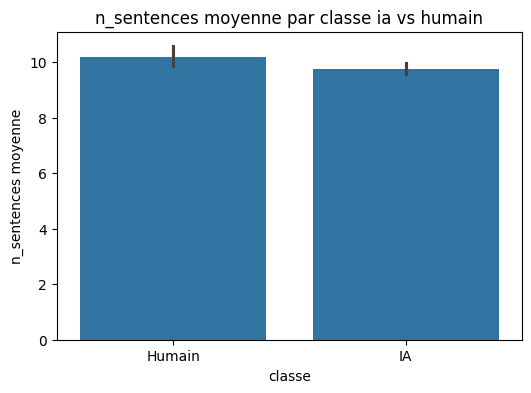

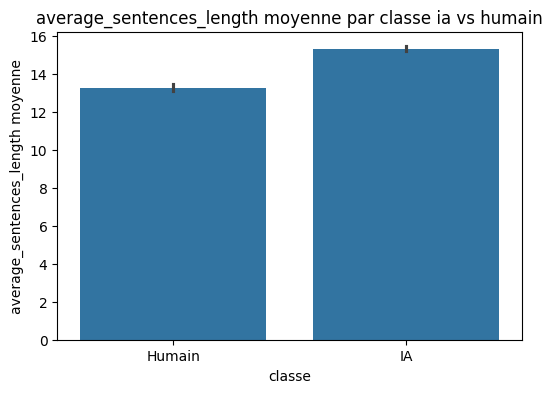

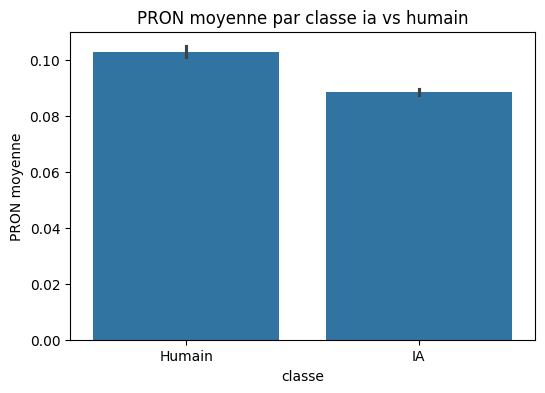

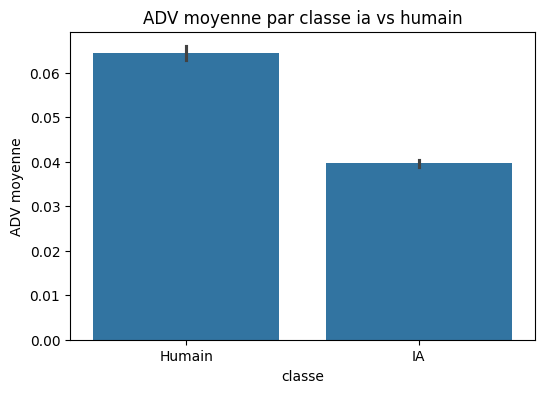

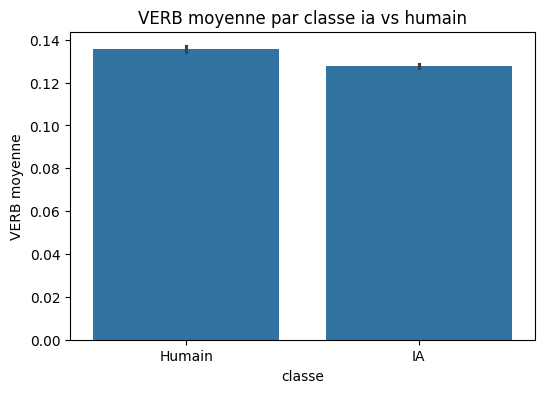

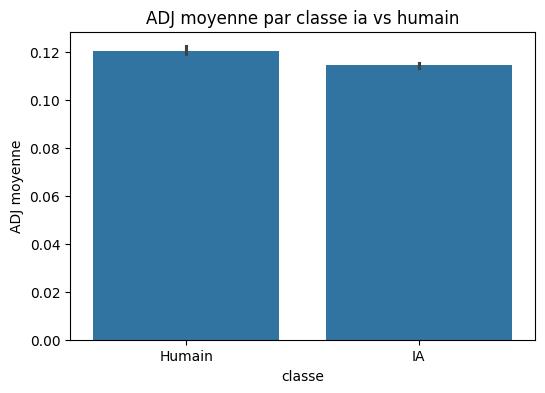

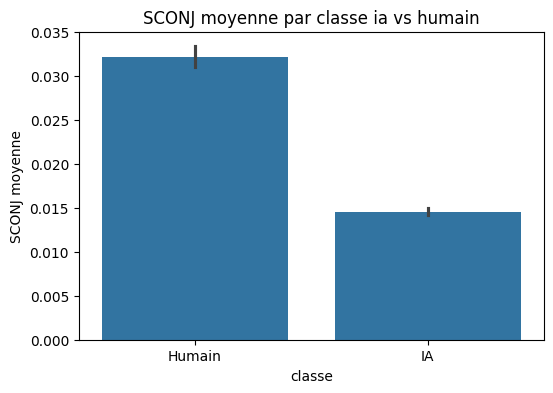

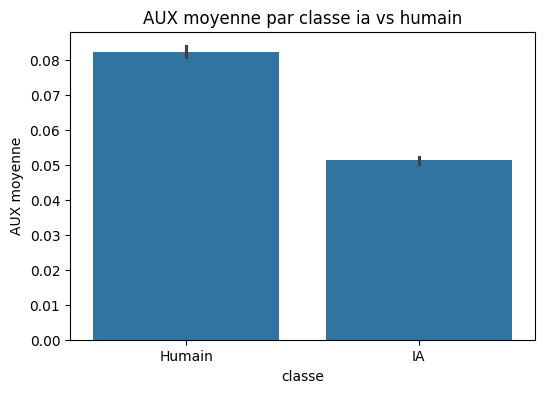

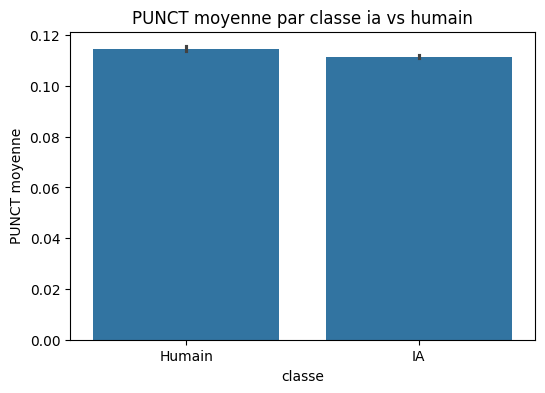

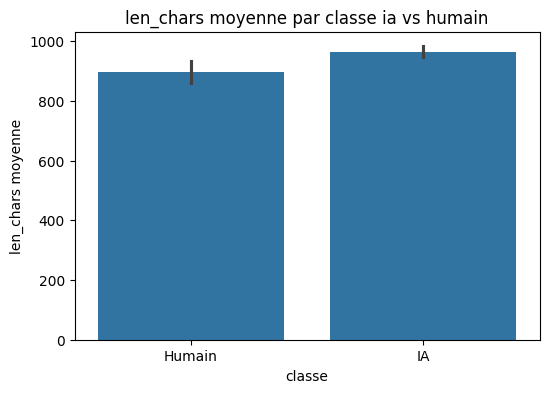

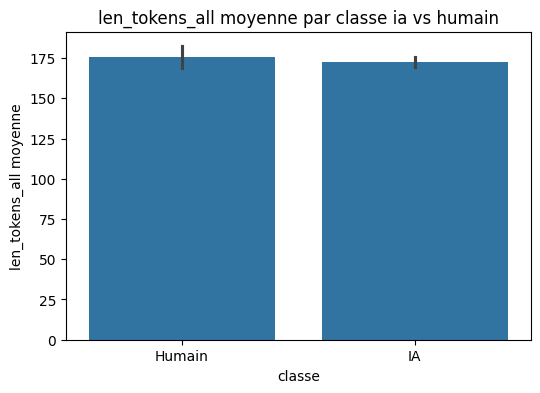

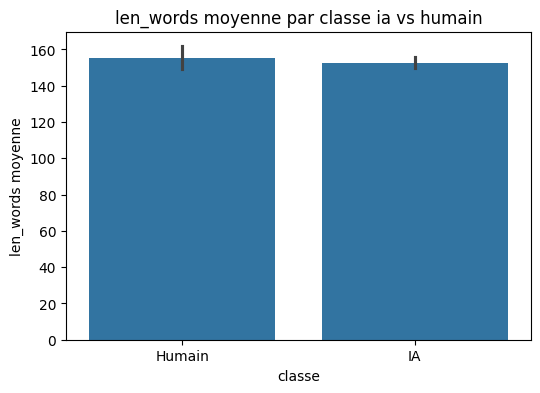

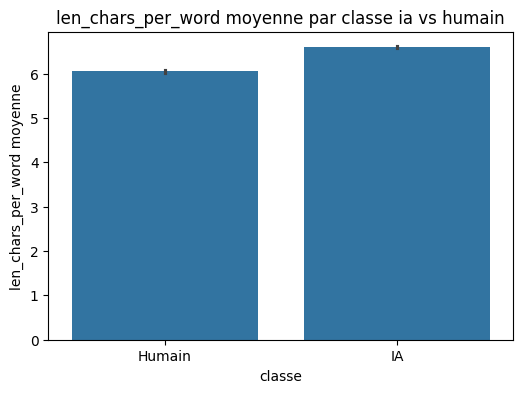

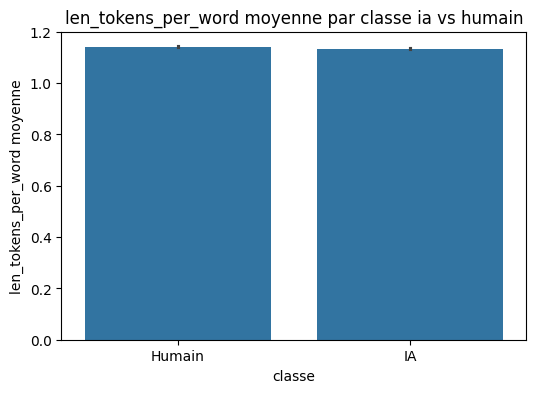

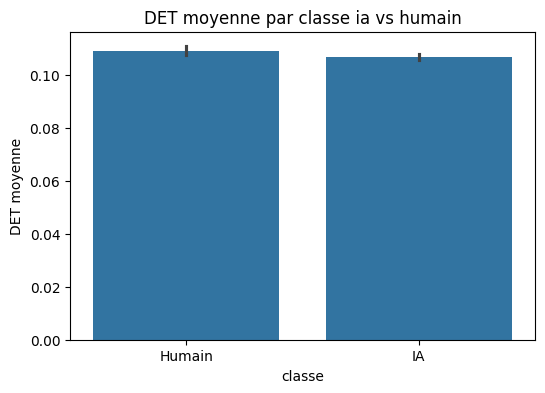

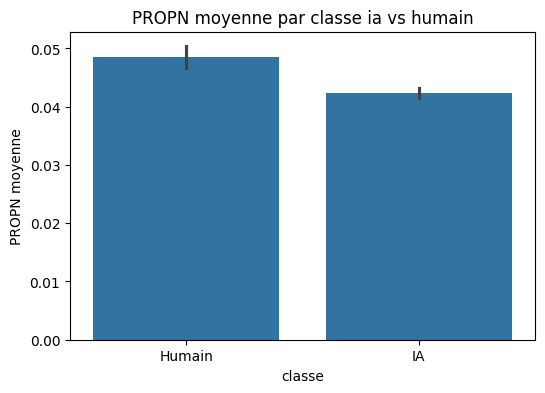

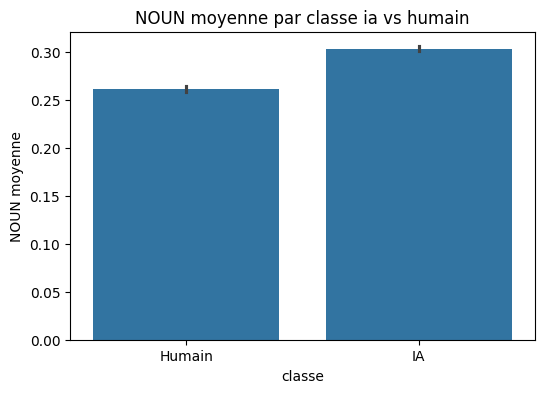

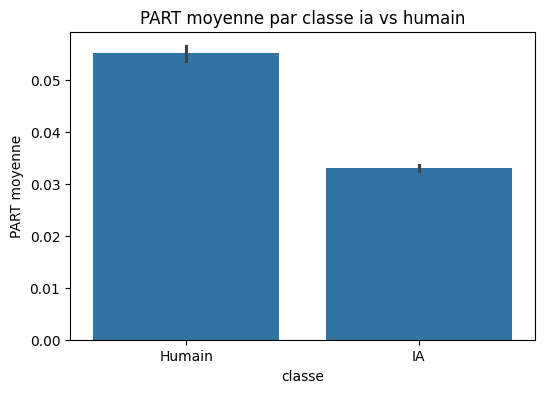

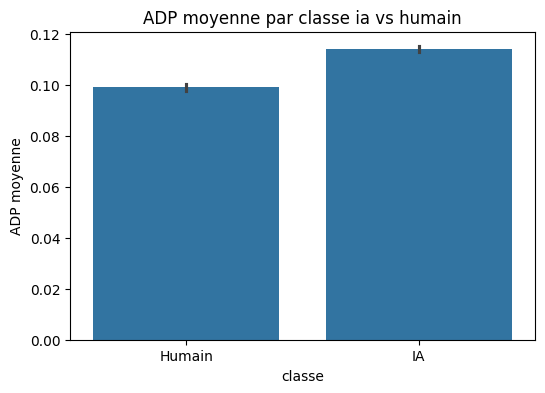

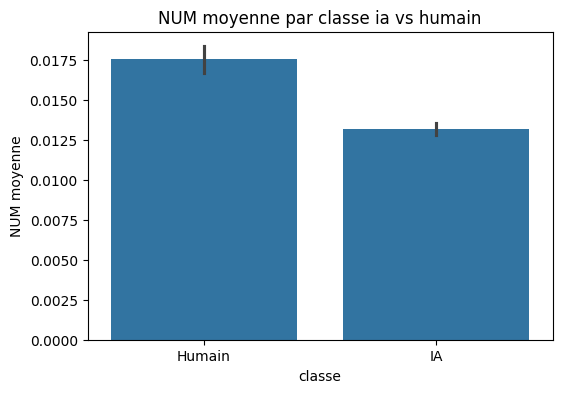

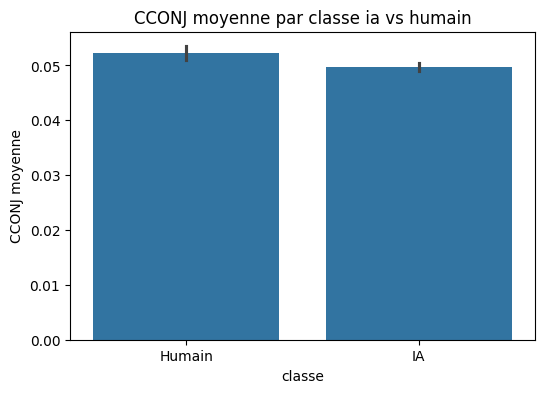

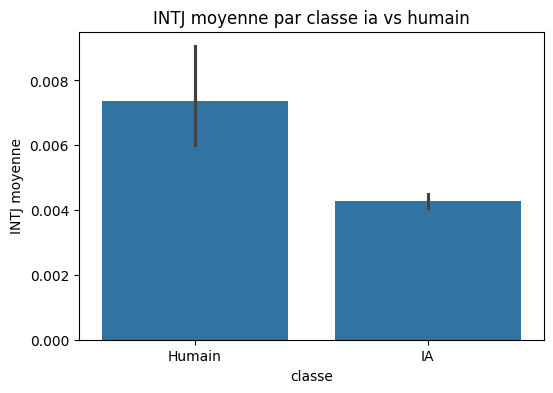

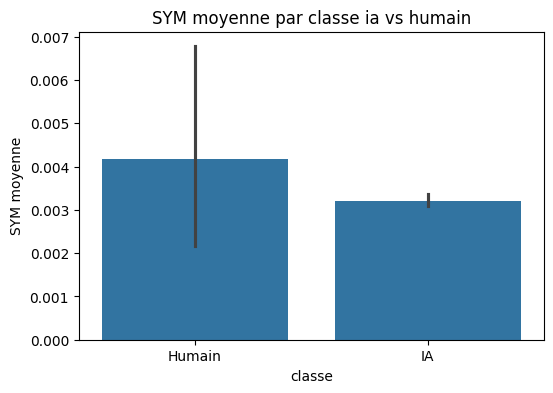

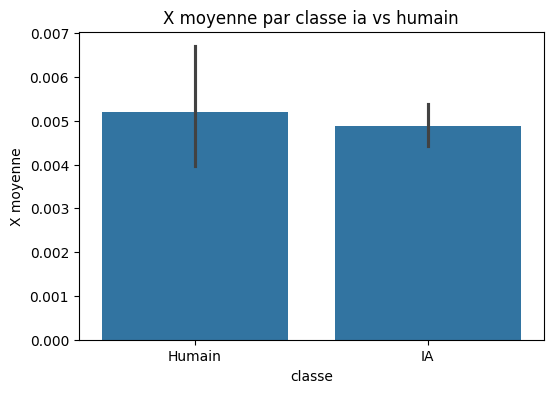

In [47]:
#Fonction sortant automatiquement les graphes pour chaque feature
def plot_features(df, features_list=None):
  """Affiche un barplot IA vs Human pour chaque feature numérique du DataFrame."""

  if features_list is None:
    features_list = df.select_dtypes(include=[np.number]).columns.tolist()

  #Filtrer pour ne garder que les colonnes numériques
  features_list = [f for f in features_list if pd.api.types.is_numeric_dtype(df[f])]

  for feature in features_list:
    plt.figure(figsize=(6,4))

    sns.barplot(data=df, x="classe", y=feature, estimator="mean", errorbar=("ci", 95))
    plt.title(f"{feature} moyenne par classe ia vs humain")
    plt.ylabel(f"{feature} moyenne")
    plt.xlabel("classe")
    plt.show()

#Sortir les graphes
plot_features(df_syntax)

## 4.5 Diversité lexicale et sémantique

### 4.5.1 Richesse lexicale (TTR)

**Mesurer la richesse lexicale brute**

TTR (Type-Token Ratio) = nombre de mots distincts / nombre total de mots.

MATTR (Moving-Average TTR) ou MTLD (Mesure de diversité lexicale plus robuste, moins dépendante de la longueur du texte).
👉 Hypothèse : IA aura un TTR plus faible, car elle recycle plus les mêmes termes.

In [48]:
def type_token_ratio(tokens):
    return len(set(tokens)) / len(tokens) if tokens else 0

ia_ttr = type_token_ratio(ia_tokens)
human_ttr = type_token_ratio(hu_tokens)

print(f"TTR IA : {ia_ttr:.3f}")
print(f"TTR Humain : {human_ttr:.3f}")

TTR IA : 0.018
TTR Humain : 0.019


Insight: IA a un TTR plus fort, donc plus diversifié, mais pb d'effet de longueur.

In [49]:
# 1) S'assurer que df["bert_words"] est une liste de tokens
df["bert_words"] = df["bert_words"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 2) Utilitaires : garder les "vrais" mots (lettres/chiffres), exclure ponctuation
word_re = re.compile(r"^[a-z0-9]+$")  # tokens alphanum en minuscule (bert-base-uncased)

def words_only(tokens):
    return [t for t in tokens if word_re.match(t)]

def ttr(tokens):
    tokens = words_only(tokens)
    return (len(set(tokens)) / len(tokens)) if tokens else 0.0

# 3) Calcul TTR par texte
df["ttr_per_text"] = df["bert_words"].apply(ttr)
df["token_count_words"] = df["bert_words"].apply(lambda ts: len(words_only(ts)))  # utile pour contrôle de longueur

# 4) Option recommandé : filtrer les textes trop courts (ex. < 5 mots)
min_words = 5
df_ttr = df[df["token_count_words"] >= min_words].copy()

# 5) Stats par classe
summary = (
    df_ttr.groupby("classe")["ttr_per_text"]
    .agg(n="count", mean="mean", median="median", std="std")
    .round(3)
    .reset_index()
)
print("Résumé TTR par texte (hors ponctuation) :")
display(summary)

# 6) Test Mann–Whitney (IA vs Humain)
ia_vals = df_ttr[df_ttr["classe"]=="IA"]["ttr_per_text"]
hum_vals = df_ttr[df_ttr["classe"]=="Humain"]["ttr_per_text"]

U, p = mannwhitneyu(ia_vals, hum_vals, alternative="two-sided")
print(f"Mann–Whitney U = {U:.2f} | p-value = {p:.4f}")
if p < 0.05:
    print("✅ Différence significative de TTR entre IA et Humain (par texte).")
else:
    print("❌ Pas de différence significative détectée (par texte).")

# 7) (Option) Interprétation automatique courte
direction = "plus élevé" if ia_vals.median() > hum_vals.median() else "plus faible"
print(f"Médiane TTR IA: {ia_vals.median():.3f} | Médiane TTR Humain: {hum_vals.median():.3f} -> TTR IA {direction}.")


Résumé TTR par texte (hors ponctuation) :


,classe,n,mean,median,std
0,Humain,5790,0.833,1.000,0.238
1,IA,10309,0.793,0.875,0.199


Mann–Whitney U = 26229809.50 | p-value = 0.0000
✅ Différence significative de TTR entre IA et Humain (par texte).
Médiane TTR IA: 0.875 | Médiane TTR Humain: 1.000 -> TTR IA plus faible.


**Conclusion :**
Au vu des textes courts, la richesse lexicale intra-texte (TTR, MATTR, etc.) n’apporte pas grand-chose.
Je passe aux synonymes / diversité sémantique qui pourrait être pertinente pour différencier style IA vs Humain.


### 4.5.2 Diversité sémantique (clustering embeddings BERT)

In [50]:
#Filtre "mots" (hors ponctuation) : tokens alphanum (minuscule avec bert-base-uncased)
word_re = re.compile(r"^[a-z0-9]+$")
def words_only(tokens):
    return [t for t in tokens if word_re.match(t)]

#Aplatir par classe
ia_tokens = [w for ws in df[df["classe"]=="IA"]["bert_words"] for w in words_only(ws)]
hu_tokens = [w for ws in df[df["classe"]=="Humain"]["bert_words"] for w in words_only(ws)]

#Comptes de fréquence
ia_freq = Counter(ia_tokens)
hu_freq = Counter(hu_tokens)
print(f"IA tokens: {sum(ia_freq.values())} | types: {len(ia_freq)}")
print(f"Humain tokens: {sum(hu_freq.values())} | types: {len(hu_freq)}")


IA tokens: 1588577 | types: 28698
Humain tokens: 914017 | types: 17705


Insight: tendance a plus de repetitions chez l'Humain.

In [51]:
# --- Bloc 1 : Vocabulaire filtré
min_count = 3   # ↑ si trop de bruit ; ↓ si on veut garder des registres rares
min_len = 3
stops = set(ENGLISH_STOP_WORDS)

def keep_word(w, f):
    return (len(w) >= min_len) and (w not in stops) and (f >= min_count)

ia_vocab = {w for w, f in ia_freq.items() if keep_word(w, f)}
hu_vocab = {w for w, f in hu_freq.items() if keep_word(w, f)}

vocab_all = sorted(list(ia_vocab | hu_vocab))
print(f"Vocabulaire retenu: {len(vocab_all)} (IA {len(ia_vocab)}, Humain {len(hu_vocab)})")

# (Option) Limiter au top-N global si trop gros
limit_topN = None  # ex. 5000
if limit_topN:
    global_freq = ia_freq + hu_freq
    vocab_all = [w for w, _ in global_freq.most_common(limit_topN) if w in set(vocab_all)]
    print(f"Vocab limité à top-{limit_topN}: {len(vocab_all)}")


Vocabulaire retenu: 15261 (IA 12844, Humain 6387)


IA a un vocabulaire plus diversifié.

In [52]:
# --- Bloc 2 : Embeddings BERT pour les mots
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "bert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)
mdl = AutoModel.from_pretrained(model_name).to(device)
mdl.eval()

@torch.no_grad()
def embed_words(words, batch_size=128):
    vecs = []
    for i in range(0, len(words), batch_size):
        batch = words[i:i+batch_size]
        enc = tok(
            batch,
            padding=True, truncation=True, return_tensors="pt",
            add_special_tokens=False  # uniquement les WP du mot
        ).to(device)

        out = mdl(**enc).last_hidden_state  # [B, T, H]
        mask = enc["attention_mask"].unsqueeze(-1)  # [B, T, 1]
        summed = (out * mask).sum(dim=1)            # [B, H]
        counts = mask.sum(dim=1).clamp(min=1)       # [B, 1]
        avg = summed / counts                       # moyenne des WP
        vecs.append(avg.cpu().numpy())
    return np.vstack(vecs)

word_vecs = embed_words(vocab_all, batch_size=128)
print("Embeddings shape:", word_vecs.shape)  # (V, 768)

c:\Users\Julien Rouillard\Anaconda3\envs\authenticheck_eda\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embeddings shape: (15261, 768)


In [53]:
# --- Bloc 3 : K-means sur les embeddings de mots ---
k = 50  # point de départ : 30–80 selon taille du vocabulaire
kmeans_model = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_assignments = kmeans_model.fit_predict(word_vecs)

#Index utiles
word2idx = {w: i for i, w in enumerate(vocab_all)}
idx2word = {i: w for i, w in enumerate(vocab_all)}

#Mots regroupés par cluster
from collections import defaultdict
cluster2words = defaultdict(list)
for i, cluster_id in enumerate(cluster_assignments):
    cluster2words[cluster_id].append(idx2word[i])

print("Exemple cluster 0 :", cluster2words[0][:15])

Exemple cluster 0 : ['252', '260', '343', '422', 'abuzz', 'aie', 'aiguo', 'aii', 'ais', 'anime', 'appendix', 'birthday', 'carfree', 'chinese', 'chosing']


In [54]:
# --- Bloc 4 : Répartition & diversité des clusters ---
def cluster_distribution(tokens, vocab_set):
    c = Counter(w for w in tokens if w in vocab_set)
    dist = np.zeros(k, dtype=float)
    for w, f in c.items():
        ci = cluster_assignments[word2idx[w]]
        dist[ci] += f
    total = dist.sum()
    return dist, (dist / total if total > 0 else dist)

#Calcul des répartitions pour IA et Humain
ia_dist_raw, ia_dist = cluster_distribution(ia_tokens, set(vocab_all))
hu_dist_raw, hu_dist = cluster_distribution(hu_tokens, set(vocab_all))

#Couverture (nombre de clusters utilisés)
ia_used = int((ia_dist_raw > 0).sum())
hu_used = int((hu_dist_raw > 0).sum())
coverage_ia = ia_used / k
coverage_hu = hu_used / k

#Entropie et "evenness"
def safe_entropy(p):
    p = p[p > 0]
    return float(entropy(p, base=2)) if len(p) else 0.0

H_ia = safe_entropy(ia_dist)
H_hu = safe_entropy(hu_dist)
even_ia = H_ia / math.log2(ia_used) if ia_used > 1 else 0.0
even_hu = H_hu / math.log2(hu_used) if hu_used > 1 else 0.0

#Résumé des résultats
summary = pd.DataFrame({
    "classe": ["IA", "Humain"],
    "n_clusters": [k, k],
    "clusters_utilisés": [ia_used, hu_used],
    "couverture": [round(coverage_ia, 3), round(coverage_hu, 3)],
    "entropie_bits": [round(H_ia, 3), round(H_hu, 3)],
    "evenness": [round(even_ia, 3), round(even_hu, 3)]
})
summary

,classe,n_clusters,clusters_utilisés,couverture,entropie_bits,evenness
0,IA,50,50,1.0,5.245,0.929
1,Humain,50,50,1.0,5.185,0.919


In [55]:
# --- Bloc 5 : Clusters différenciateurs & mots représentatifs
#But : isoler les clusters où IA ou Humain dominent et lister les mots qui les caractérisent.
diff = ia_dist - hu_dist

top_ia = np.argsort(diff)[::-1][:10]   # clusters pro-IA
top_hu = np.argsort(diff)[:10]         # clusters pro-Humain

def top_words_in_cluster(c, for_class="IA", top=12):
    words = cluster2words[c]
    freq = ia_freq if for_class == "IA" else hu_freq
    pairs = sorted([(w, freq.get(w,0)) for w in words], key=lambda x: x[1], reverse=True)
    pairs = [(w,f) for w,f in pairs if f > 0][:top]
    return pairs

def table_side_by_side(cluster_ids, title):
    rows = []
    for cid in cluster_ids:
        rows.append({
            "cluster": int(cid),
            "part_IA_%": round(float(ia_dist[cid])*100, 2),
            "part_Humain_%": round(float(hu_dist[cid])*100, 2),
            "écart(IA-Hu)%": round(float(diff[cid])*100, 2),
            "mots_repr_IA": ", ".join([w for w,_ in top_words_in_cluster(cid, "IA")]),
            "mots_repr_Humain": ", ".join([w for w,_ in top_words_in_cluster(cid, "Humain")]),
        })
    return title, pd.DataFrame(rows)

title1, df_top_ia = table_side_by_side(top_ia, "🔥 Clusters plus présents chez l’IA")
title2, df_top_hu = table_side_by_side(top_hu, "🧠 Clusters plus présents chez l’Humain")

print(title1); display(df_top_ia)
print(title2); display(df_top_hu)


🔥 Clusters plus présents chez l’IA


,cluster,part_IA_%,part_Humain_%,écart(IA-Hu)%,mots_repr_IA,mots_repr_Humain
0,44,5.52,2.60,2.92,"experience, address, data, context, potential, projects, process, client, experiences, support, insights, approach","usage, process, method, idea, experience, represent, cost, quantum, lecture, support, policy, forecast"
1,15,8.69,6.63,2.07,"project, email, challenges, impact, help, journey, positive, ensure, learning, create, feel, power","pollution, want, paris, help, change, ban, live, reason, feel, save, reasons, matter"
2,37,3.22,2.03,1.19,"involved, complex, individuals, challenging, different, overall, unique, recently, discovered, exploring, early, con...","better, different, known, responsible, decrease, beneficial, allow, avoid, increase, alternative, elected, recent"
3,35,2.83,1.81,1.02,"embarked, stands, countless, hours, conducted, street, led, set, left, memorable, market, engaging","lot, end, france, streets, dear, street, set, safety, featured, left, delicious, weekend"
4,22,2.14,1.20,0.94,"role, professional, medical, visit, leading, treatment, eye, rewarding, event, pursue, inquiries, friends","really, didn, event, selsky, economy, hand, rewarding, friends, body, role, visit, return"
5,39,4.88,4.04,0.84,"world, skills, community, information, research, industry, understanding, business, patients, human, technology, sense","use, world, smog, population, community, effect, earth, political, global, movie, living, mind"
6,34,1.25,0.42,0.82,"dedication, product, machine, sessions, transformative, operations, accuracy, cultures, completion, participants, re...","plates, reduction, paper, product, stressful, teach, image, machine, disadvantages, desired, machines, cultures"
7,19,3.18,2.42,0.76,"worked, comprehensive, working, including, received, named, successfully, required, needed, achieve, crucial, strong","rosenthal, senator, possible, true, agree, direct, fewer, favor, comes, walter, including, prefers"
8,28,5.99,5.34,0.64,"life, knowledge, ensuring, communication, case, significant, career, lives, edu, management, program, dedicated","popular, environment, percent, life, example, using, thee, campaign, right, point, swing, ways"
9,49,1.56,1.02,0.54,"patient, share, provide, specific, detailed, www, age, causing, require, dental, members, analyzed","voted, caused, changed, residents, share, causes, age, prevent, provide, specific, member, causing"


🧠 Clusters plus présents chez l’Humain


,cluster,part_IA_%,part_Humain_%,écart(IA-Hu)%,mots_repr_IA,mots_repr_Humain
0,17,5.30,9.23,-3.93,"work, team, com, way, connect, questions, vision, training, particular, language, beauty, road","college, vote, votes, way, transportation, good, cities, know, traffic, work, place, party"
1,45,1.16,4.84,-3.69,"city, small, university, craft, taking, short, discovery, cutting, hesitate, ready, immersed, held","electoral, states, city, don, having, fair, means, says, small, taking, ones, richard"
2,29,0.93,2.32,-1.39,"care, education, students, staff, officer, cars, child, assistance, student, appointment, benefit, employee","cars, citizens, pay, benefit, care, elector, drivers, opinion, obama, education, relate, foreign"
3,23,1.64,3.03,-1.39,"people, need, heart, needs, pain, personal, bring, reinforced, brought, climate, things, joy","people, need, bogota, walk, things, vehicles, personal, needs, everyday, banned, bring, andrew"
4,16,1.97,3.27,-1.30,"make, situation, related, filled, months, aimed, old, driven, moments, shared, seasoned, car","car, make, lower, main, conclusion, old, suburb, south, calm, smaller, entire, green"
5,4,1.86,3.12,-1.26,"new, local, health, effectively, public, air, person, variety, difficult, order, relationship, relief","voters, air, new, public, person, instead, elect, democratic, american, health, local, fall"
6,41,1.78,2.85,-1.07,"day, home, met, driving, knew, immediately, thought, sharing, west, leaving, mark, thinking","driving, day, away, said, house, happen, home, thought, pick, author, yes, easy"
7,40,2.83,3.27,-0.44,"time, exceptional, meticulous, carefully, reached, open, msn, mrs, privilege, smith, bustling, areas","time, say, money, unfair, stay, weather, areas, huge, doesn, close, sure, maybe"
8,20,1.35,1.69,-0.34,"making, thrilled, healthy, edge, additionally, approached, graduating, talented, gained, avid, remember, utilized","going, getting, makes, happier, 2000, making, bush, suffer, presidents, florida, carlos, healthy"
9,36,1.32,1.62,-0.30,"number, thorough, past, resulted, clear, major, promptly, confident, curiosity, ensured, completed, trial","number, paragraph, clear, decide, won, slate, major, past, lose, kind, half, pretty"


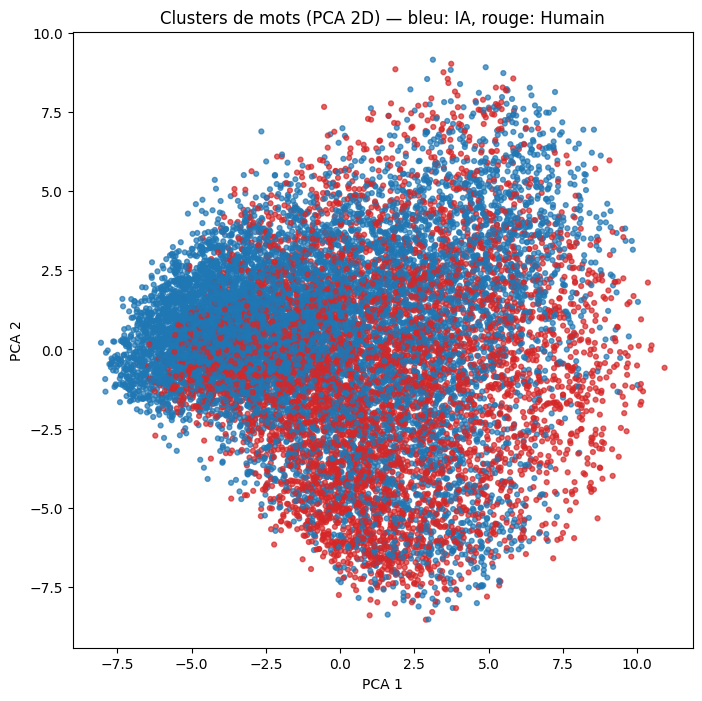

In [56]:
# --- Bloc 6 : PCA 2D (optionnel) ---
do_plot = True  # passer à False si on ne veut pas tracer

if do_plot:
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(word_vecs)

    cluster_diff = diff  # IA - Humain à l’échelle des clusters
    colors = ["#1f77b4" if cluster_diff[c] >= 0 else "#d62728" for c in cluster_assignments]

    plt.figure(figsize=(8, 8))
    plt.scatter(X2[:, 0], X2[:, 1], s=12, c=colors, alpha=0.7)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("Clusters de mots (PCA 2D) — bleu: IA, rouge: Humain")
    plt.show()

##4.6 Analyse N-Grammes

In [57]:
# === Fonction DRY pour comparer les n-grammes entre IA et Humain ===
from sklearn.feature_extraction.text import CountVectorizer


def compare_ngrams(text_ia, text_humain, ngram_range=(1,1), top=5000, threshold=0.01):
    """
    Compare les n-grammes entre textes IA et Humains.
    Retourne le DataFrame complet + les n-grammes discriminants.
    """
    def get_top_ngrams(corpus, ngram_range=(1,1), top=5000):
        vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:top]

    df_ia = pd.DataFrame(get_top_ngrams(text_ia, ngram_range, top), columns=["gram", "freq_ia"])
    df_humain = pd.DataFrame(get_top_ngrams(text_humain, ngram_range, top), columns=["gram", "freq_humain"])

    df_compare = pd.merge(df_ia, df_humain, on="gram", how="outer").fillna(0)
    df_compare["freq_ia_norm"] = df_compare["freq_ia"] / df_compare["freq_ia"].sum()
    df_compare["freq_humain_norm"] = df_compare["freq_humain"] / df_compare["freq_humain"].sum()
    df_compare["diff_norm"] = df_compare["freq_ia_norm"] - df_compare["freq_humain_norm"]

    top_ia = df_compare[df_compare["diff_norm"] > threshold].sort_values("diff_norm", ascending=False)
    top_human = df_compare[df_compare["diff_norm"] < -threshold].sort_values("diff_norm", ascending=True)

    return df_compare, top_ia, top_human

# === Fonction de visualisation des n-grammes discriminants ===
def plot_top_ngrams(df, title="Top n-grammes discriminants (IA vs Humain)", top_n=20):
    top = df.sort_values("diff_norm", key=abs, ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="diff_norm", y="gram", data=top, palette="coolwarm")
    plt.title(title)
    plt.xlabel("Différence relative IA - Humain")
    plt.ylabel("N-grammes")
    plt.tight_layout()
    plt.show()

Nombre d'unigrammes typiques IA : 0
Nombre d'unigrammes typiques Humain : 6

Nombre de bigrammes typiques IA : 0
Nombre de bigrammes typiques Humain : 3

Nombre de trigrammes typiques IA : 0
Nombre de trigrammes typiques Humain : 1


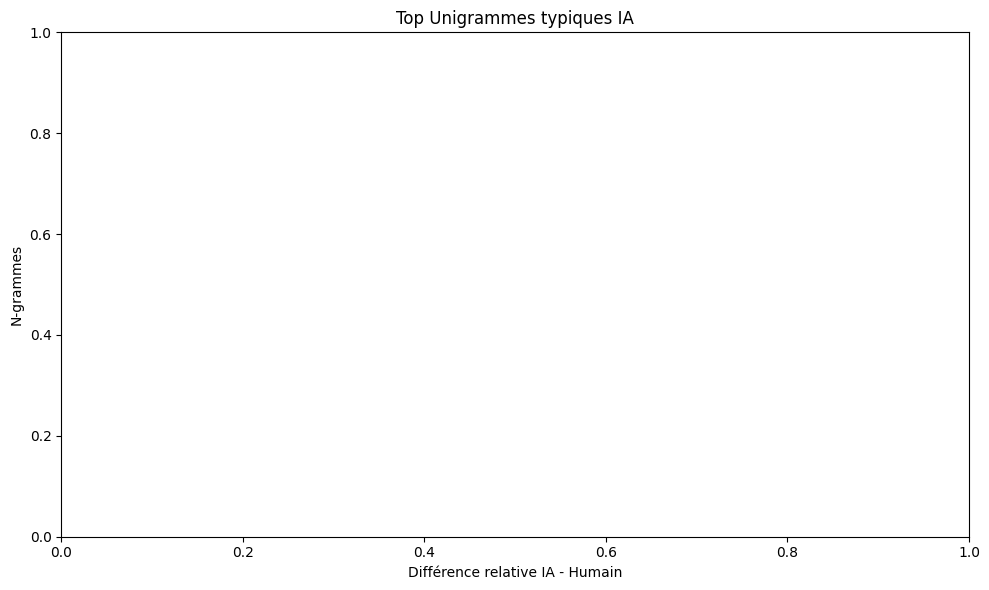

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\1101002936.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="diff_norm", y="gram", data=top, palette="coolwarm")


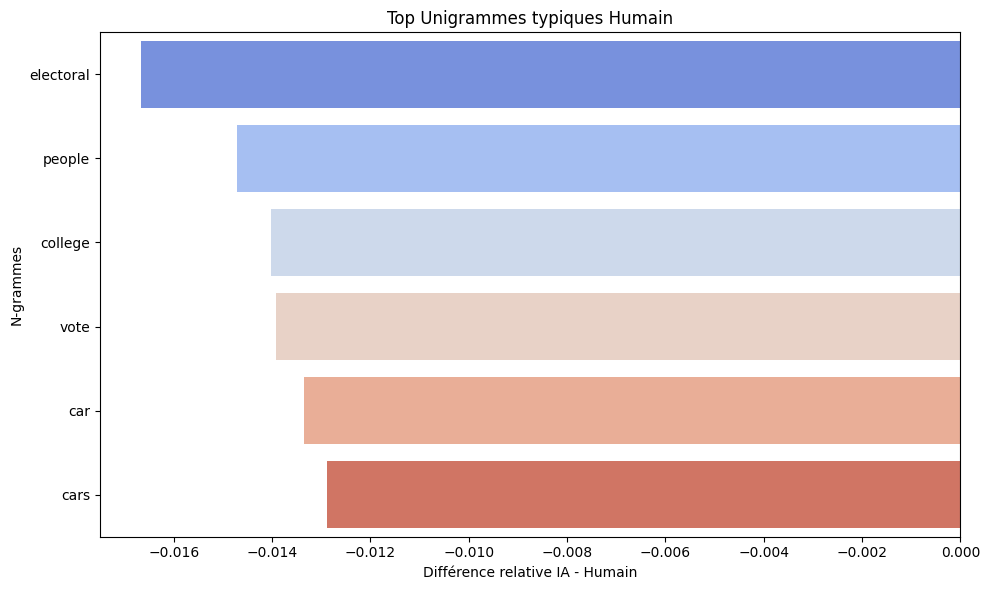

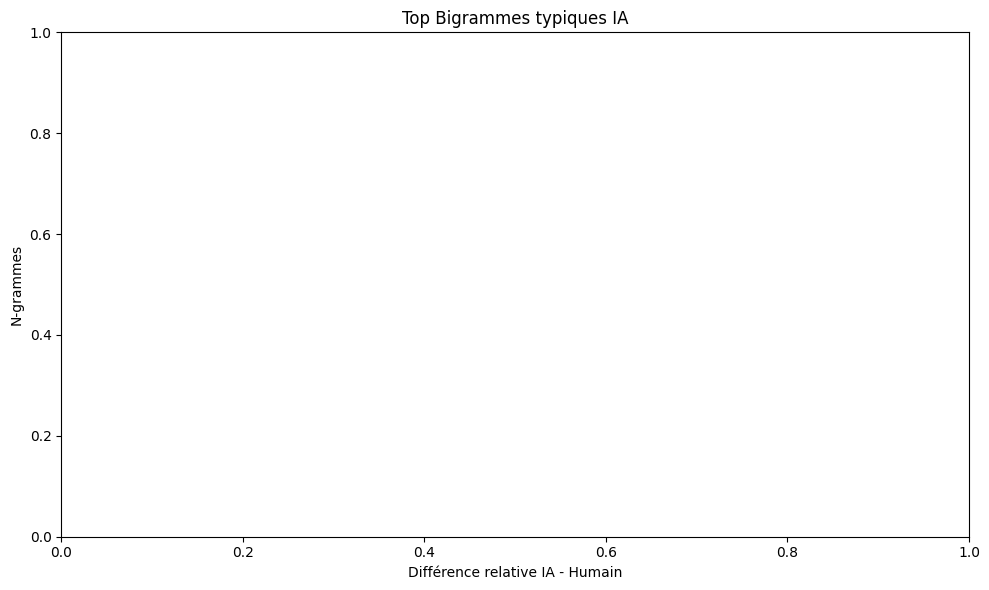

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_18940\1101002936.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="diff_norm", y="gram", data=top, palette="coolwarm")


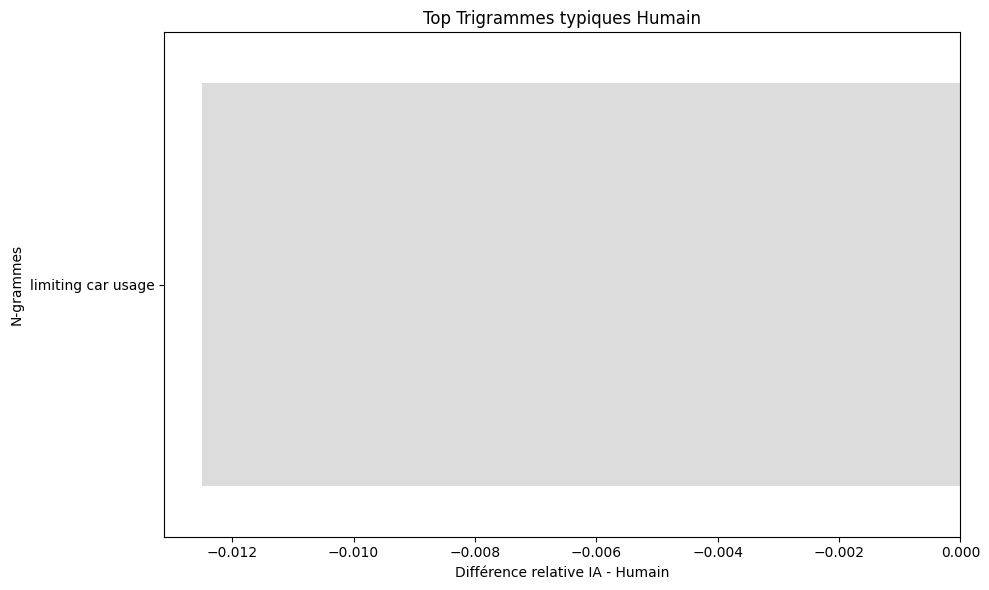

In [58]:
# === Textes normalisés par classe ===
text_ia = df[df['classe'] == 'IA']["text_norm"]
text_humain = df[df['classe'] == 'Humain']["text_norm"]

# === Comparaison des unigrammes, bigrammes, trigrammes ===
df_uni, top_uni_ia, top_uni_human = compare_ngrams(text_ia, text_humain, (1,1))
df_bi, top_bi_ia, top_bi_human = compare_ngrams(text_ia, text_humain, (2,2))
df_tri, top_tri_ia, top_tri_human = compare_ngrams(text_ia, text_humain, (3,3))

# === Résumé des résultats ===
print("Nombre d'unigrammes typiques IA :", len(top_uni_ia))
print("Nombre d'unigrammes typiques Humain :", len(top_uni_human))
print("\nNombre de bigrammes typiques IA :", len(top_bi_ia))
print("Nombre de bigrammes typiques Humain :", len(top_bi_human))
print("\nNombre de trigrammes typiques IA :", len(top_tri_ia))
print("Nombre de trigrammes typiques Humain :", len(top_tri_human))

# === Visualisations (exemple) ===
plot_top_ngrams(top_uni_ia, title="Top Unigrammes typiques IA")
plot_top_ngrams(top_uni_human, title="Top Unigrammes typiques Humain")
plot_top_ngrams(top_bi_ia, title="Top Bigrammes typiques IA")
plot_top_ngrams(top_tri_human, title="Top Trigrammes typiques Humain")

# Conclusion des Analyse Exploratoires et Linguistiques

Les features qui semblent différenciantes:

VERB
DET
ADJ
ADP
PUNCT
CCONJ
AUX
PROPN
NUM
Les features qui semblent très différenciantes:

NOUN
SCONJ
PTON
Les features qui semblent pas ou peu différenciantes:

n_sentences
average_sentences
ADV
PART

# Extraction des features

## 5.1 Feature Longueur des elements: Phrases, mots, caracteres

In [59]:
texts = df["text"].astype(str).tolist()  # S'assurer que toutes les entrées sont des chaînes

len_chars_list = []
len_tokens_all_list = []
len_words_list = []

for doc in nlp.pipe(texts, batch_size=256):
    toks = list(doc)
    len_chars_list.append(len(doc.text))  # nombre de caractères (espaces inclus)
    len_tokens_all_list.append(len(toks))  # nombre total de tokens spaCy
    len_words_list.append(sum(1 for t in toks if _is_word_tok(t)))  # nombre de mots filtrés

#Convertir en séries Pandas
len_chars_series = pd.Series(len_chars_list, index=df.index)
len_tokens_all_series = pd.Series(len_tokens_all_list, index=df.index)
len_words_series = pd.Series(len_words_list, index=df.index)

#Préparer dénominateur sûr (évite division par zéro)
denominator = len_words_series.replace(0, 1).fillna(1)

#Calcul des ratios uniquement
df["len_chars_per_word"] = len_chars_series / denominator
df["len_tokens_per_word"] = len_tokens_all_series / denominator

#Ajouter la série len words au dataframe
df['len_words'] = len_words_series

## 5.2 Feature top_words - A retirer selon moi

In [60]:
def get_class_pos_proportions_docs(docs):
    total_counts = Counter()
    total_tokens = 0
    for doc in docs:
        tokens = [t for t in doc if not t.is_space]
        total_counts.update(t.pos_ for t in tokens)
        total_tokens += len(tokens)
    if total_tokens == 0:
        return {}
    return {pos: (count / total_tokens) * 100 for pos, count in total_counts.items()}

#Exemple d'extraction par classe (avec échantillons équilibrés)
human_docs = df[df["classe"] == "Humain"]["doc"].tolist()
ai_docs = df[df["classe"] == "IA"]["doc"].tolist()

ia_pos_ratios = get_class_pos_proportions_docs(ai_docs)
human_pos_ratios = get_class_pos_proportions_docs(human_docs)

## 5.3 Feature Ratio Majuscule

In [61]:
def extract_uppercase_ratio(df, text_col="text"):
    """
    Ajoute une colonne avec la fréquence de caractères majuscules dans le texte.
    """
    df = df.copy()  # éviter de modifier df en place

    # Calcul nombre de majuscules par texte
    nb_uppercase = df[text_col].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Calcul longueur texte (nombre total de caractères)
    len_text = df[text_col].apply(lambda x: len(str(x))).replace(0, 1)  # éviter division par zéro

    # Calcul ratio majuscules / caractères
    df["freq_uppercase"] = nb_uppercase / len_text

    return df

## 5.4 Feature Ponctuation

In [62]:
print(type(df["len_words"]))
print(df["len_words"].head())

<class 'pandas.core.series.Series'>
0     8
1     6
2    14
3    11
4    13
Name: len_words, dtype: int64


In [64]:
import re

PUNCT_LIST = ['!', '?', ',', '.', ';', ':', '"', "'", '(', ')']
ELLIPSIS_TOKEN = '...'

def _punctuation_features(text, len_words_value):
    text = text or ""
    res = {}
    ellipses = text.count(ELLIPSIS_TOKEN)
    text_wo_ell = text.replace(ELLIPSIS_TOKEN, "")
    denominator = max(len_words_value, 1)
    res['punct_ellipsis_ratio'] = ellipses / denominator
    for p in PUNCT_LIST:
        cleaned_p = re.sub(r'\W', '_', p)
        key = f"punct_{cleaned_p}_ratio"
        count = text_wo_ell.count(p)
        res[key] = count / denominator
    return res

len_words = df["len_words"].fillna(1).replace(0, 1).to_list()
texts = df['text'].astype(str).tolist()

punct_features = [_punctuation_features(text, lw) for text, lw in zip(texts, len_words)]

punct_df = pd.DataFrame(punct_features)

df = pd.concat([df.reset_index(drop=True), punct_df.reset_index(drop=True)], axis=1)

## 5.5 StopWords (ratio)

In [65]:
#Stopwords (Ratio)---
def count_stopwords(words, stop_words):
    if not words:  # None ou liste vide
        return 0
    return sum(1 for w in words if w.lower() in stop_words)

#Calcul direct du ratio stopwords / nombre total mots
df["stopwords_ratio"] = df.apply(
    lambda row: count_stopwords(row["bert_words"], stop_words) / max(row["bert_words_len"], 1),
    axis=1
)

# Verification
print(df[[TEXT_COL, "bert_words_len", "stopwords_ratio"]].head())

                                                                text  \
0                        It always seems impossible until it's done.   
1                     She finished the challenging crossword puzzle.   
2  You can't use up creativity. The more you use, the more you have.   
3         The journey of a thousand miles begins with a single step.   
4               Life is short, and it is up to you to make it sweet.   

   bert_words_len  stopwords_ratio  
0              10         0.400000  
1               7         0.285714  
2              18         0.611111  
3              12         0.416667  
4              15         0.600000  


## 5.6 Feature Connecteurs logiques - A retirer selon moi

In [66]:
# --- 9) Connecteurs logiques -----
#Étape 1 : Extraire toutes les catégories disponibles (depuis le dictionnaire initial)
connective_categories = list(connectives.keys())

#Étape 2 : Créer une colonne par catégorie avec le ratio (count / len_words)
for cat in connective_categories:
    df[f"connective_{cat}_ratio"] = df["connective_counts"].apply(lambda c: c.get(cat, 0)) / df["len_words"].replace(0, 1)

# Verification
cols = [col for col in df.columns if col.startswith("connective_") and col.endswith("_ratio")]
print(df[cols].head())

   connective_addition_ratio  connective_contrast_ratio  \
0                   0.000000                        0.0   
1                   0.000000                        0.0   
2                   0.000000                        0.0   
3                   0.090909                        0.0   
4                   0.076923                        0.0   

   connective_cause_ratio  connective_consequence_ratio  \
0                     0.0                           0.0   
1                     0.0                           0.0   
2                     0.0                           0.0   
3                     0.0                           0.0   
4                     0.0                           0.0   

   connective_concession_ratio  connective_example_ratio  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                    

# Création du dataset

In [67]:
# --- 10) Verification
# Colonnes à exclure explicitement car ce ne sont pas des features numériques exploitables
EXCLUDE_COLS = ['text', 'text_norm', 'doc', 'connective_counts', 'bert_words']

# Colonnes non numériques (objet, liste, dict) à exclure dynamiquement
non_numeric_cols = [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col])]

# Colonnes à exclure globalement (exclues explicitement + non numériques + cible 'classe')
cols_to_exclude = set(EXCLUDE_COLS + non_numeric_cols + ['classe'])

# Construction finale du df_features avec uniquement colonnes numériques utiles
numeric_feature_cols = [col for col in df.columns if col not in cols_to_exclude]

df_features = df[numeric_feature_cols].copy()

# Vérification rapide
print(f"Nombre de features numériques extraites : {len(numeric_feature_cols)}")
print(f"Colonnes exclues : {sorted(cols_to_exclude)}")

# Optionnel : aperçu rapide
display(df_features.head(3))

Nombre de features numériques extraites : 49
Colonnes exclues : ['bert_ids', 'bert_words', 'bert_wp', 'classe', 'connective_counts', 'connectives_detected', 'doc', 'emojis', 'punctuation_list', 'text', 'text_norm']


,label,bert_wp_len,bert_ids_len,bert_words_len,nb_mots,longueur,len,frequency_uppercase,n_stopwords,stopwords_ratio,n_connectives,personal_refs,n_sentences,average_sentences_length,PRON,ADV,VERB,ADJ,SCONJ,AUX,PUNCT,len_chars,len_tokens_all,len_words,len_chars_per_word,len_tokens_per_word,DET,PROPN,NOUN,PART,ADP,NUM,CCONJ,INTJ,SYM,X,ttr_per_text,token_count_words,punct_ellipsis_ratio,punct___ratio,connective_addition_ratio,connective_contrast_ratio,connective_cause_ratio,connective_consequence_ratio,connective_concession_ratio,connective_example_ratio,connective_purpose_ratio,connective_time_ratio,connective_summary_ratio
0,0,10,12,10,7,43,43,0.023256,4,0.400000,0,0,1,9.0,0.222222,0.111111,0.222222,0.111111,0.111111,0.111111,0.111111,43,9,8,5.375000,1.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875000,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,8,10,7,6,46,46,0.021739,2,0.285714,0,0,1,7.0,0.142857,NaN,0.142857,0.142857,NaN,NaN,0.142857,46,7,6,7.666667,1.166667,0.142857,0.142857,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,18,20,18,13,65,65,0.030769,11,0.611111,0,0,2,8.5,0.294118,0.117647,0.176471,NaN,NaN,0.058824,0.176471,65,17,14,4.642857,1.214286,NaN,NaN,0.058824,0.058824,0.058824,NaN,NaN,NaN,NaN,NaN,0.642857,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
#Définition du chemin de sauvegarde
out_path = "../datasets_source/features_compilation_ml.csv"

#Sauvegarde du DataFrame dans le fichier CSV
#df_features.to_csv(out_path, index=False)